## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'erb-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_erb_1e5rawre_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\erb\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


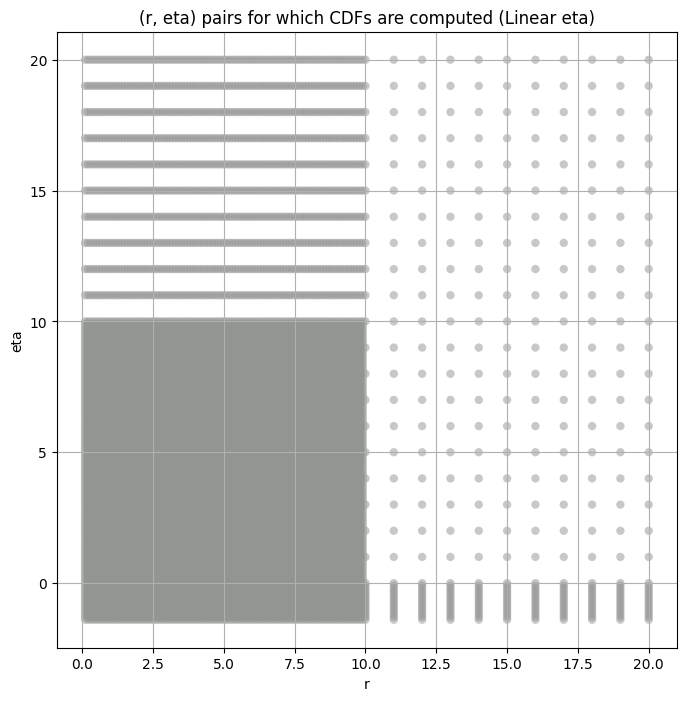

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 12


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 16


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.016542   0.012634   0.021451  103.542736   54.898436  147.181190   
3     0.167863   0.131724   0.208685   77.699289   61.912070   97.018422   
5     1.805418   1.643466   1.973467   10.639768    9.269359   12.145156   
6     1.522237   1.389193   1.659050    9.897320    8.832308   11.013223   
8     0.189349   0.163776   0.218549   29.697767   20.258654   40.649249   
9     0.046160   0.041017   0.052375   20.315265   11.214986   46.298195   
11    0.016417   0.013539   0.019882   52.739324   32.215677  100.260013   
12    0.006926   0.005489   0.008856   84.103175   44.060635  193.098712   
14    0.000442   0.000345   0.000612  126.152679   41.820439  427.664160   
16    0.000100   0.000063   0.000159  343.486872  118.174578  840.164724   

      total_samples  
band                 
2           98473.0  
3          109656.0  
5         1086255.0  
6          548700.0  
8         3556612.0  
9         5336598.0  
11        6762724.0  
12       22271101.0  
14       12539235.0  
16        8199664.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     0.016542       0.016542        0.013643        0.012023        0.011005   
3     0.167863       0.167863        0.149545        0.135878        0.124516   
5     1.805418       1.805418        1.757946        1.719736        1.685286   
6     1.522237       1.522237        1.489074        1.459930        1.433036   
8     0.189349       0.189349        0.175146        0.166192        0.159199   
9     0.046160       0.046160        0.043235        0.041707        0.040524   
11    0.016417       0.016417        0.014701        0.013737        0.012990   
12    0.006926       0.006926        0.005971        0.005486        0.005120   
14    0.000442       0.000442        0.000374        0.000345        0.000322   
16    0.000100       0.000100        0.000069        0.000058        0.000050   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            0.010235         0.009222         0.008595         0.008131   
3            0.114720         0.098429         0.085898         0.076444   
5            1.653634         1.596166         1.544756         1.497899   
6            1.407965         1.361774         1.319726         1.281086   
8            0.153364         0.143935         0.136414         0.130133   
9            0.039534         0.037907         0.036569         0.035419   
11           0.012368         0.011360         0.010557         0.009891   
12           0.004821         0.004347         0.003977         0.003674   
14           0.000304         0.000275         0.000253         0.000234   
16           0.000044         0.000037         0.000031         0.000027   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            0.007761         0.007459         0.006789  
3            0.069076         0.063066         0.049877  
5            1.454756         1.414803         1.309478  
6            1.245281         1.211944         1.122984  
8            0.124722         0.119961         0.108387  
9            0.034396         0.033473         0.031122  
11           0.009322         0.008828         0.007654  
12           0.003419         0.003200         0.002689  
14           0.000219         0.000205         0.000173  
16           0.000024         0.000022         0.000017

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.00782761178788463 0.016542308909729055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.006552676349234621 0.01364349305112573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.00445443932845313 0.012023010214528453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.005826772934477392 0.011005026368226088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.006670256369016414 0.010235475198781473


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.004066924839963931 0.009222352819158662


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.005552012737655709 0.008595133972112413


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.0069956909420553215 0.008131381147053017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.004642777452637192 0.0077613827380622995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.006527872783183314 0.007459453969658665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007716487306096698 0.006788710299097692
Number of samples: 100000, Without approximation : 98473.0


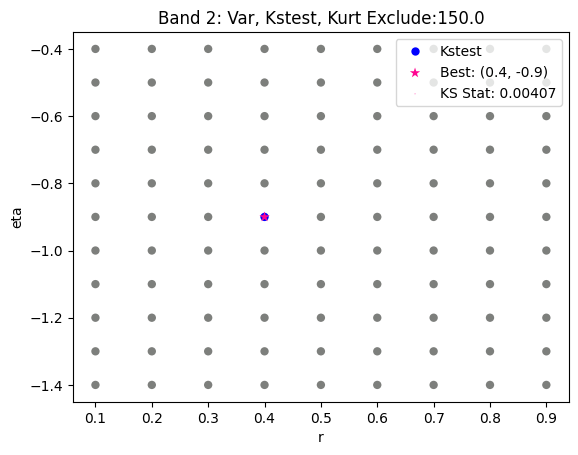

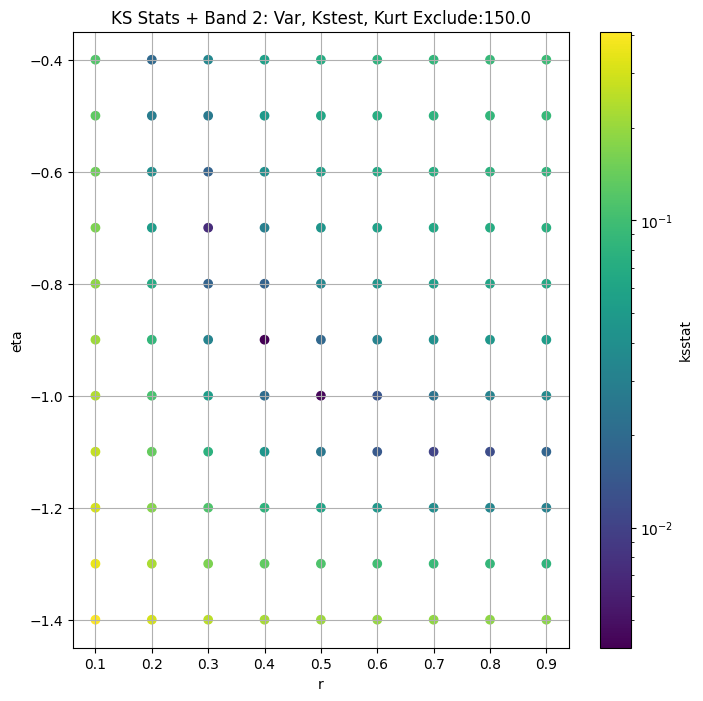

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.02408406512117478 0.16786310082713746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.02327473841695732 0.14954482917793316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.026522048296430845 0.13587797893802128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.024193142923918276 0.12451562318430753


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.020670504350149277 0.11472004810418995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.018074615280336936 0.09842855698486895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.019373955968708723 0.08589799657532944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.013753563044075823 0.07644361080756908


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.013724946852074094 0.06907599159748307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.015616387517027541 0.0630657451286342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.011023243373011212 0.049877267191251094
Number of samples: 100000, Without approximation : 109656.0


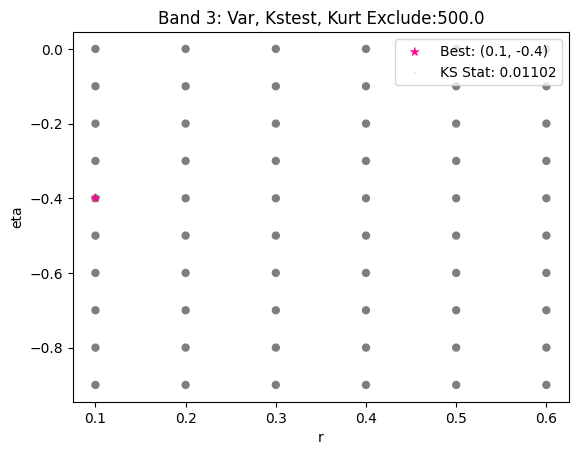

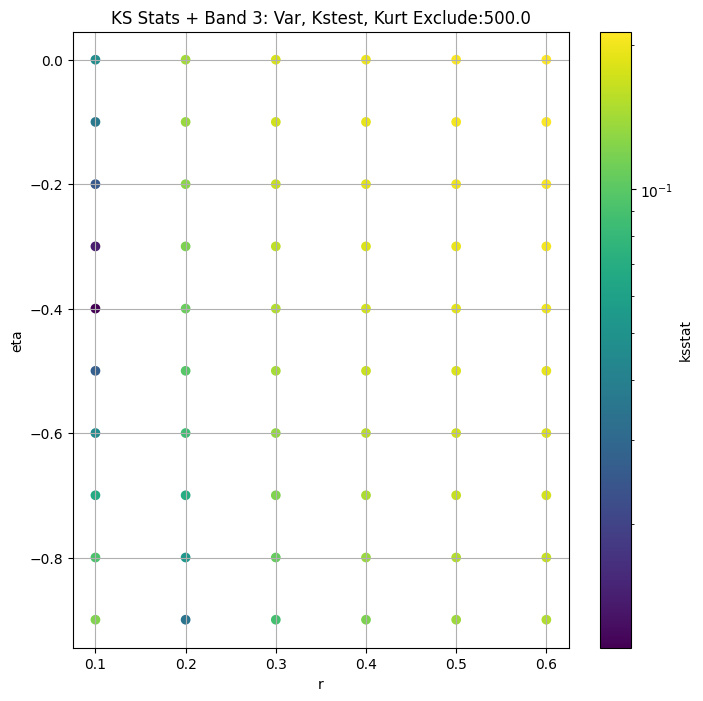

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.013692452565176039 1.8054182074758667


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.012489183851237207 1.757946071415464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011493613261154612 1.7197360455286428


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.010583902593285122 1.6852856651531638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.010861935317615479 1.6536339789055587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.012271723231328885 1.5961658577183702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.013571775910014405 1.5447563043711199


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.014812531502602075 1.4978987602189837


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.01600346983484402 1.4547560753976563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.016482149357095133 1.4148027250131245


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.015091348766643892 1.3094783442900637
Number of samples: 100000, Without approximation : 1086255.0


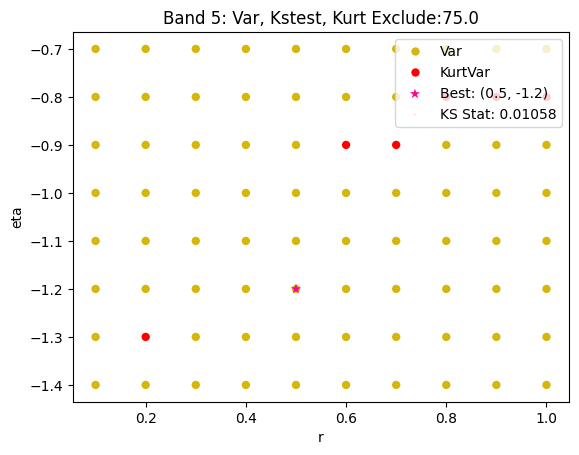

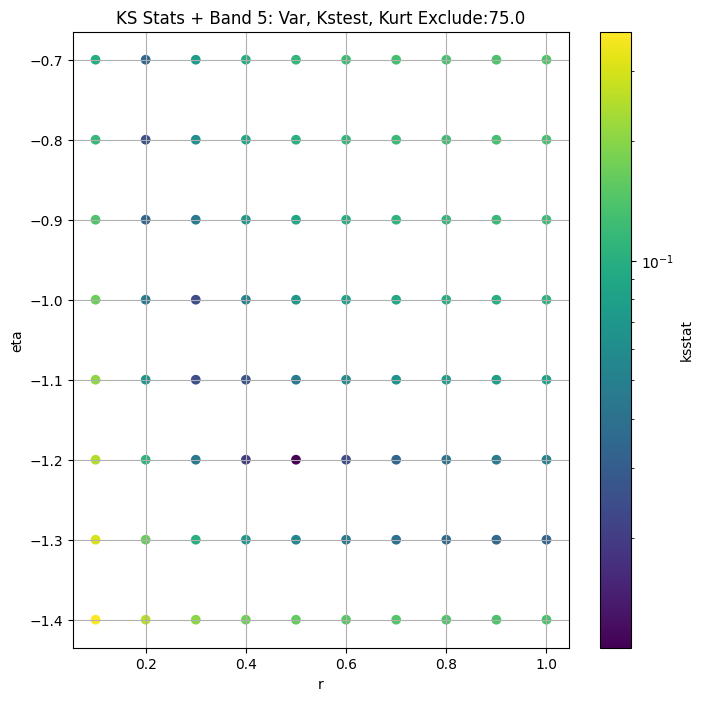

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011804453769707512 1.522237153819995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.010730828428692274 1.4890739229110228


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011003884465737135 1.4599295172639724


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.011261987590329758 1.4330363155770618


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.011525578871713738 1.407964667416205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.01204493919085503 1.361773769100132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.012561417836116695 1.3197255906413836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.01342010465219616 1.2810861142160936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.014397293699978227 1.245280945573338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.014616008623103971 1.2119440367600498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.014290646325715063 1.1229839798964278
Number of samples: 100000, Without approximation : 548700.0


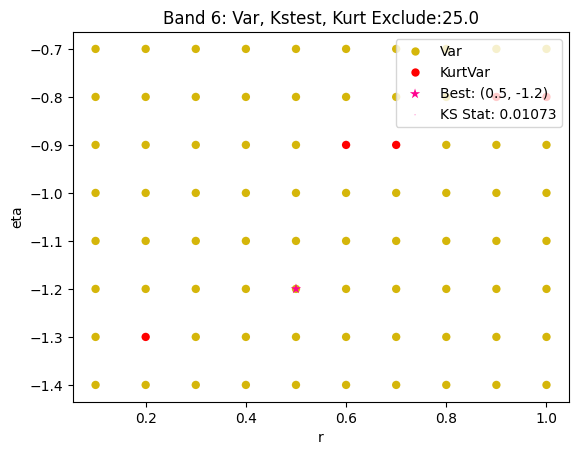

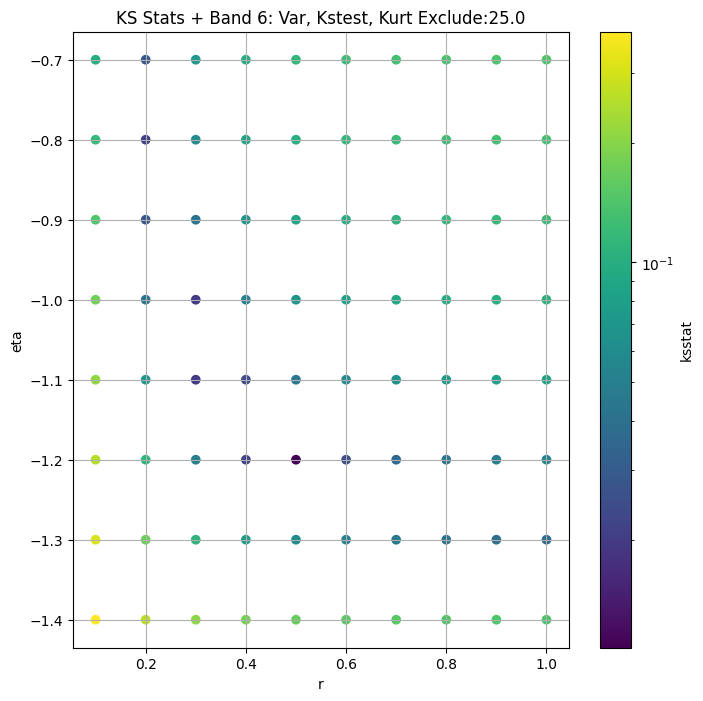

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.00444589971703796 0.1893492897532852


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006511366315126665 0.17514582790588323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.00808291115355747 0.16619232658601943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.009563102285532421 0.15919897238419597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.009095091025246416 0.15336380571680602


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0068665636982098155 0.14393546918703254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0040510150866418515 0.13641364493760505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.005658189753118242 0.1301330848287458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0077226062324538824 0.1247216229650644


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.009677181748066921 0.1199612565191952


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.009113376699252954 0.10838707009908118
Number of samples: 100000, Without approximation : 3556612.0


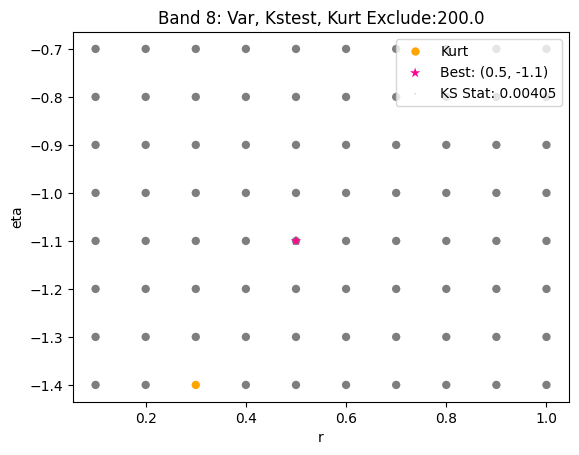

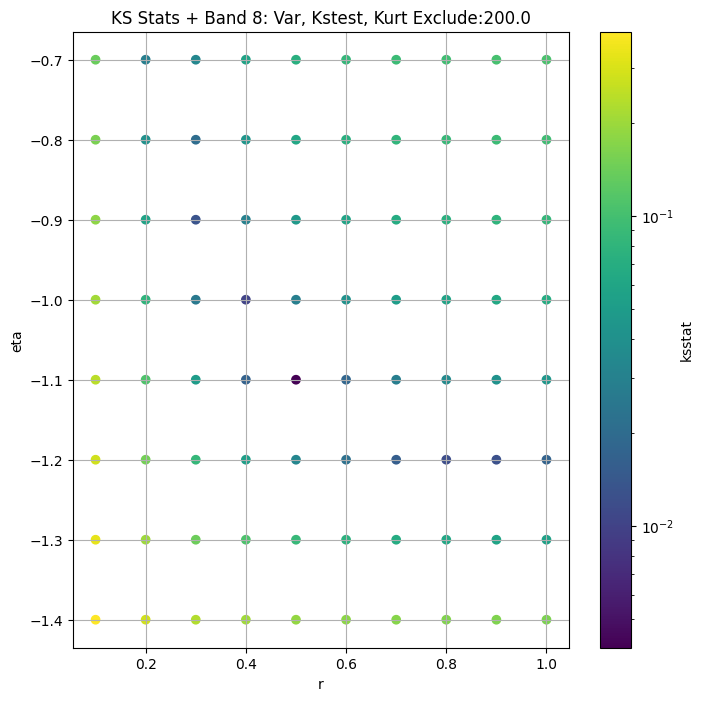

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.0034483654060425972 0.04615971873525968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.007137553154559773 0.04323545577044636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.009002558977357522 0.041707293636536254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.007732363825261324 0.040524279006687015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006641348999193442 0.03953423465510472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.006753400789200156 0.037906560805046674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.008508780165315102 0.0365694255595598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.008399377182000012 0.035418585153114863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008184381850382838 0.03439640000338535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.00804328186825748 0.033472523481619894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.00781793335161407 0.031121711242018978
Number of samples: 100000, Without approximation : 5336598.0


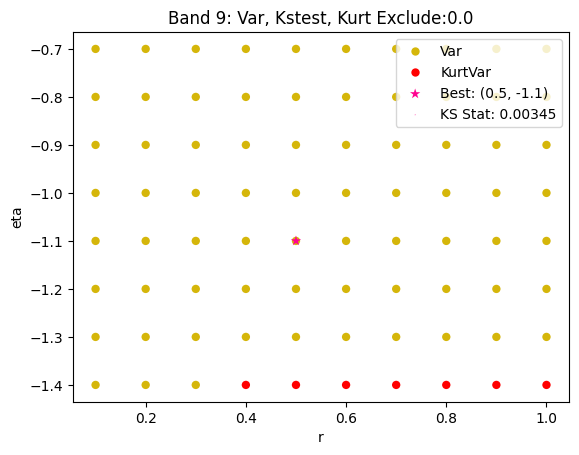

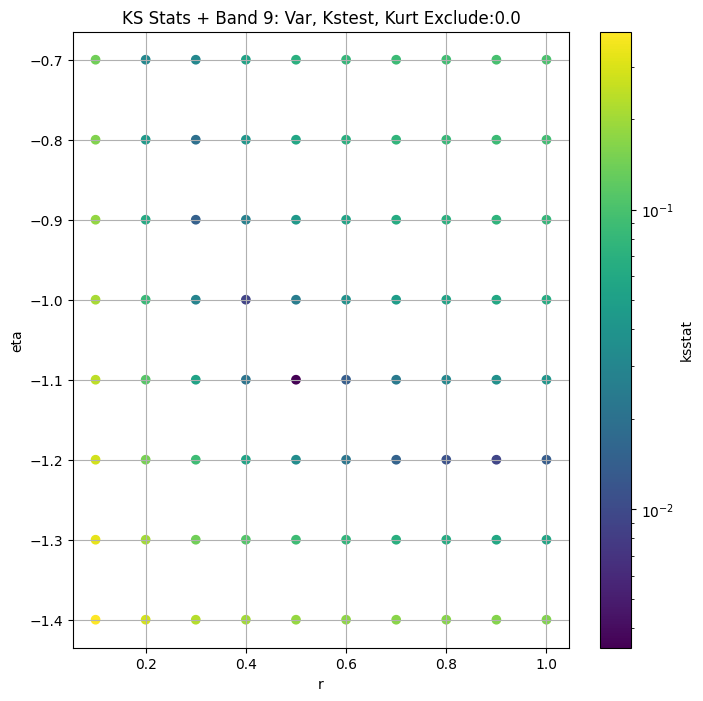

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.010724815209590316 0.01641717683948446


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.011749037106338789 0.014700644779295035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.009071942586031279 0.013737292972254499


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.006968301070906957 0.01299040892344953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.006609872888869148 0.012367912152797134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.007589870178577818 0.011359627033061223


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.008475542121437307 0.010556747008030831


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.009339842107679686 0.00989063674684799


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.01078434124481037 0.00932194998233782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.013253869119548331 0.008827746373721494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.012712990786361011 0.0076535553836058375
Number of samples: 100000, Without approximation : 6762724.0


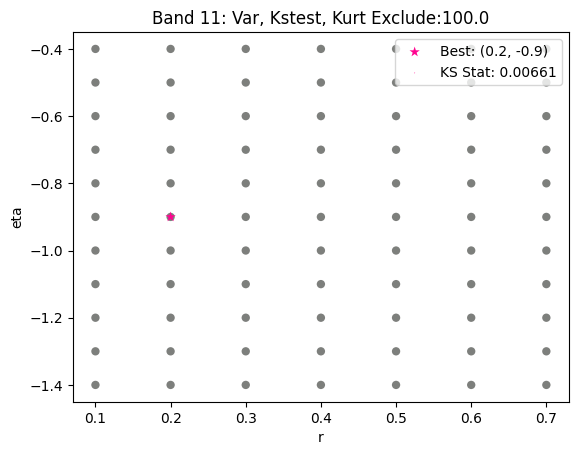

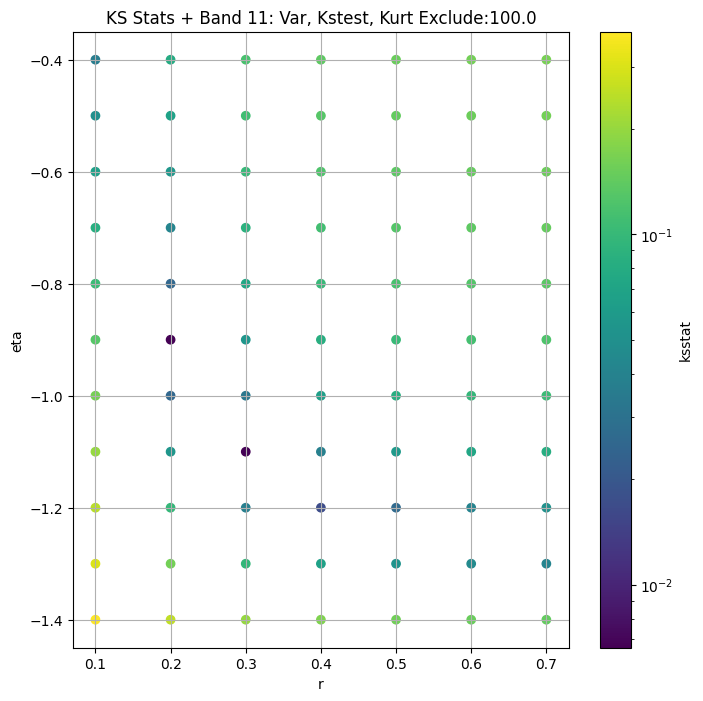

####
Band  12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 0 0.009333260507539243 0.0069256422651946935


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 25 0.004749220682636723 0.005970641570312991


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 50 0.007471887605347449 0.005486244537446575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 75 0.008827266269113954 0.0051200987709984465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 100 0.009501570243010238 0.004821448749693666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 150 0.008213146514620934 0.004347251523846662


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 200 0.008737250321828927 0.003976734076562311


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 250 0.006253159094207938 0.0036739958010142035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 300 0.00729882548155926 0.003419008975822902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 350 0.008376506525848915 0.003199732380510027


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 500 0.0111596199168425 0.0026886323051187153
Number of samples: 100000, Without approximation : 22271101.0


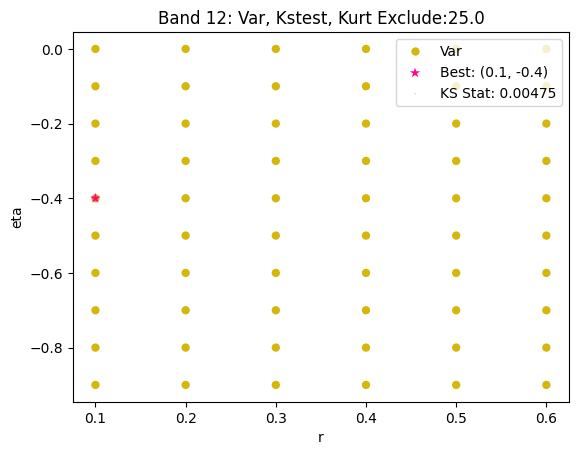

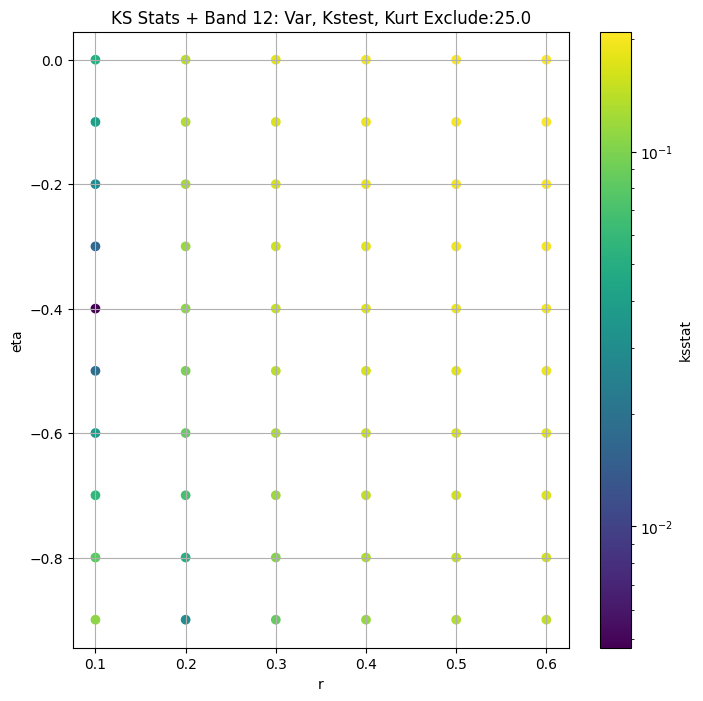

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.008172299355460377 0.00044216679136780876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.0031554130253352766 0.0003741864145214418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.00474888945818272 0.00034456335797917065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.005658703604046966 0.00032231789109603146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.005150491535511267 0.00030416811361891067


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.007190462894888394 0.0002753441410053767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.007447110216087651 0.00025278812147164247


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.009348026642080821 0.00023428681281486476


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.009500249522621407 0.0002186222809222087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.007491066536990481 0.00020511534361547103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.010565992089254905 0.00017342819016066683
Number of samples: 100000, Without approximation : 12539235.0


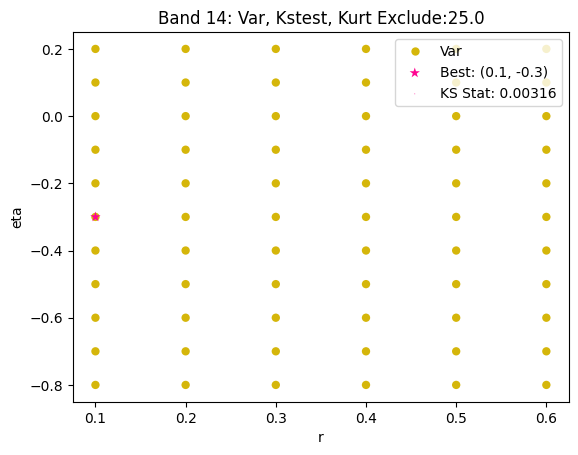

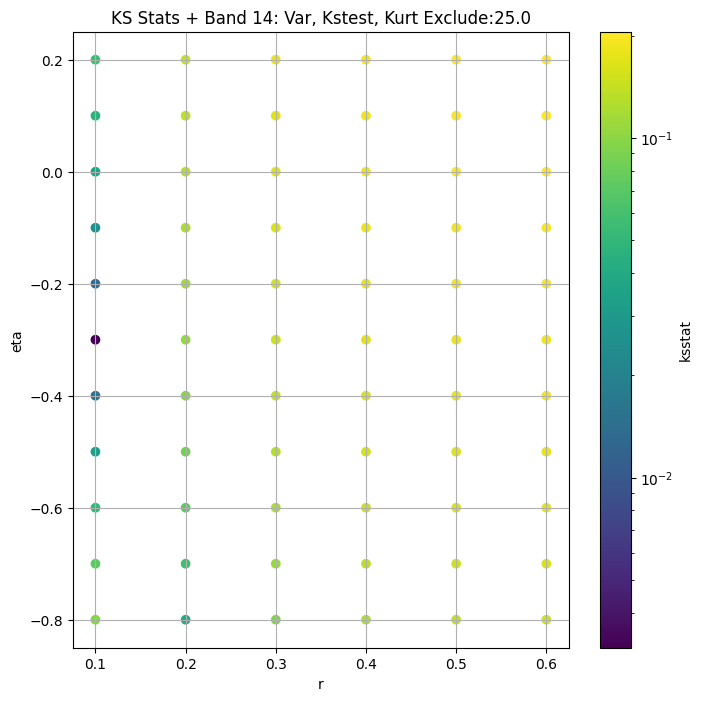

####
Band  16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 0 0.02235963581762679 9.953511140188425e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 25 0.016078814698615385 6.931762013230655e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 50 0.020377004206840077 5.7743142935921114e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 75 0.014430508990895374 5.011651382156825e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 100 0.013309345669219041 4.446991145065533e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 150 0.011702890955958445 3.6500843979653606e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 200 0.010989072911937514 3.103563398301663e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 250 0.008700495068992398 2.704102555659444e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 300 0.0076120747385119425 2.3981101422800168e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 350 0.008713598471866368 2.1549275370429475e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 500 0.011705900527158947 1.657484767174169e-05
Number of samples: 100000, Without approximation : 8199664.0


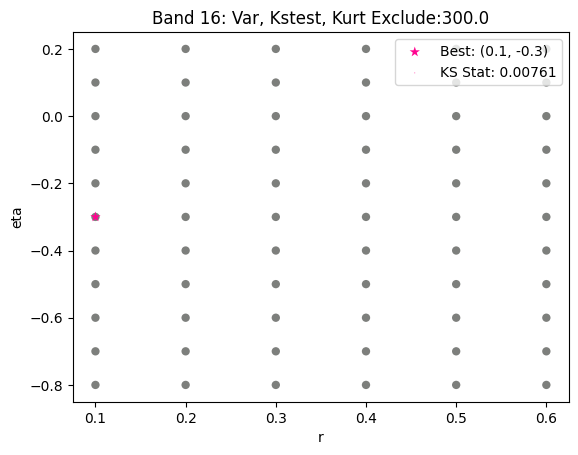

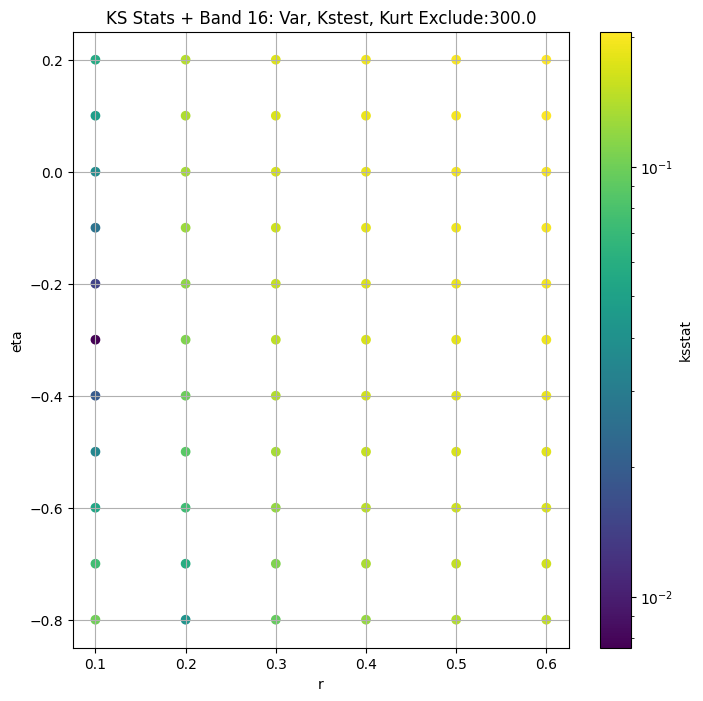

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.016542   0.012634   0.021451  103.542736   54.898436  147.181190   
3     0.167863   0.131724   0.208685   77.699289   61.912070   97.018422   
5     1.805418   1.643466   1.973467   10.639768    9.269359   12.145156   
6     1.522237   1.389193   1.659050    9.897320    8.832308   11.013223   
8     0.189349   0.163776   0.218549   29.697767   20.258654   40.649249   
9     0.046160   0.041017   0.052375   20.315265   11.214986   46.298195   
11    0.016417   0.013539   0.019882   52.739324   32.215677  100.260013   
12    0.006926   0.005489   0.008856   84.103175   44.060635  193.098712   
14    0.000442   0.000345   0.000612  126.152679   41.820439  427.664160   
16    0.000100   0.000063   0.000159  343.486872  118.174578  840.164724   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98473.0             0.004067        0.4         -0.9   
3          109656.0             0.011023        0.1         -0.4   
5         1086255.0             0.010584        0.5         -1.2   
6          548700.0             0.010731        0.5         -1.2   
8         3556612.0             0.004051        0.5         -1.1   
9         5336598.0             0.003448        0.5         -1.1   
11        6762724.0             0.006610        0.2         -0.9   
12       22271101.0             0.004749        0.1         -0.4   
14       12539235.0             0.003155        0.1         -0.3   
16        8199664.0             0.007612        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.362183e-03                   150.0            0.009222   
3      7.439454e-14                   500.0            0.049877   
5      1.755506e+00                    75.0            1.685286   
6      1.551119e+00                    25.0            1.489074   
8      9.473170e-02                   200.0            0.136414   
9      3.205536e-02                     0.0            0.046160   
11     4.907902e-06                   100.0            0.012368   
12     8.905523e-15                    25.0            0.005971   
14     2.923478e-16                    25.0            0.000374   
16     1.873617e-17                   300.0            0.000024   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004326  
3                    0.004100  
5                    0.001303  
6                    0.001833  
8                    0.000720  
9                    0.000588  
11                   0.000522  
12                   0.000288  
14                   0.000384  
16                   0.000474

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + 100 = 250, ksstat: 0.0036406597135351104, var: 0.008131381147053017


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + 75 = 225, ksstat: 0.0035137371465082667, var: 0.008349832516622436


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + 50 = 200, ksstat: 0.003118015799118412, var: 0.008595133972112413


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + 25 = 175, ksstat: 0.0029827032873354087, var: 0.00888003057166921


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + 0 = 150, ksstat: 0.003443698227249048, var: 0.009222352819158662


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + -25 = 125, ksstat: 0.002446932526411816, var: 0.009657317573053067


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + -50 = 100, ksstat: 0.00244539169673752, var: 0.010235475198781473


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + -75 = 75, ksstat: 0.0030733358782327747, var: 0.011005026368226088


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
band 2, 150.0 + -100 = 50, ksstat: 0.003924985284107341, var: 0.012023010214528453
Number of samples: 100000, Without approximation : 98473.0


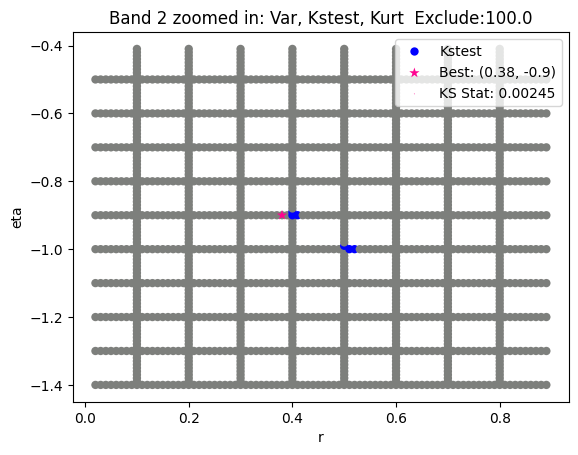

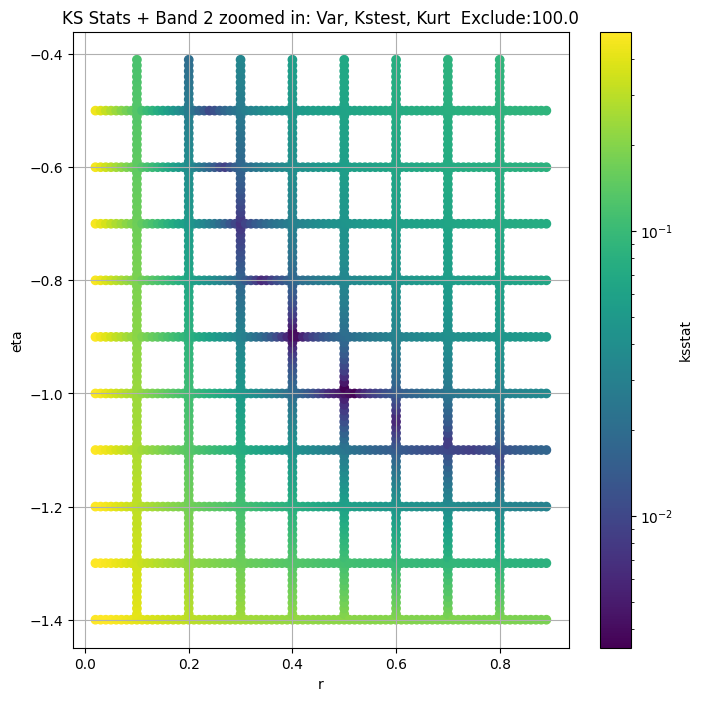

Band 3


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + 100 = 600, ksstat: 0.011214959321908736, var: 0.043469656061124955


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + 75 = 575, ksstat: 0.010949133512389632, var: 0.04494776916993393


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + 50 = 550, ksstat: 0.011193639294617115, var: 0.04650795406906018


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + 25 = 525, ksstat: 0.010956217911003669, var: 0.04815491502707672


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + 0 = 500, ksstat: 0.010731787113591677, var: 0.049877267191251094


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + -25 = 475, ksstat: 0.01031127461103394, var: 0.05170110915233727


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + -50 = 450, ksstat: 0.010306589723717565, var: 0.053658179519533646


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + -75 = 425, ksstat: 0.010079595916231048, var: 0.05576062464120586


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 3, 500.0 + -100 = 400, ksstat: 0.009846321874474626, var: 0.0580129415848006
Number of samples: 100000, Without approximation : 109656.0


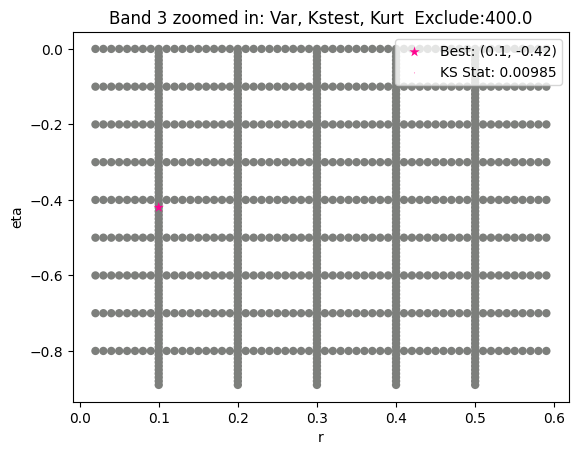

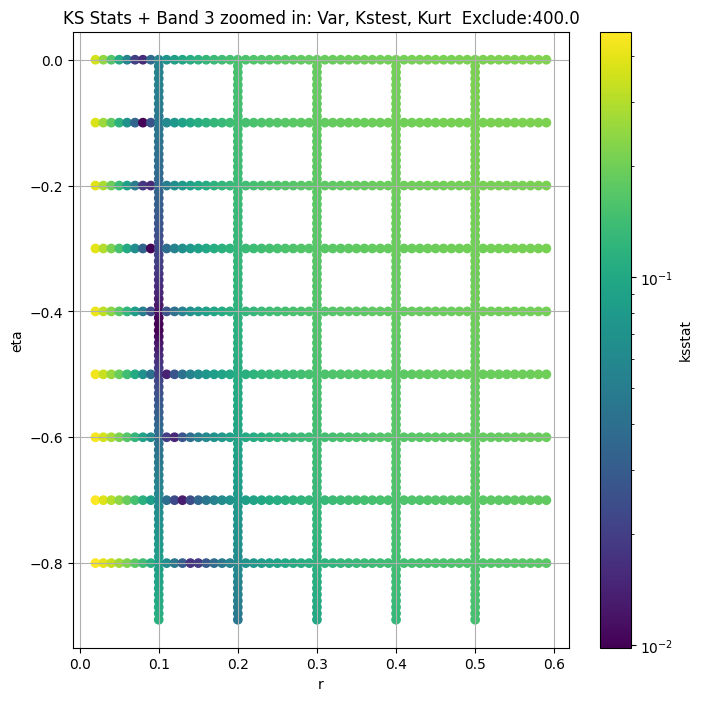

Band 5


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.011695221548584399, var: 1.5697955661407765


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.011333099756546172, var: 1.5961658577183702


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.010952752124487847, var: 1.6240656092314734


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.010861935317615479, var: 1.6536339789055587


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.010583902593285122, var: 1.6852856651531638


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.009980764460123234, var: 1.7197360455286428


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.00982573977141904, var: 1.757946071415464


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.009523111960821035, var: 1.8054182074758667
Number of samples: 100000, Without approximation : 1086255.0


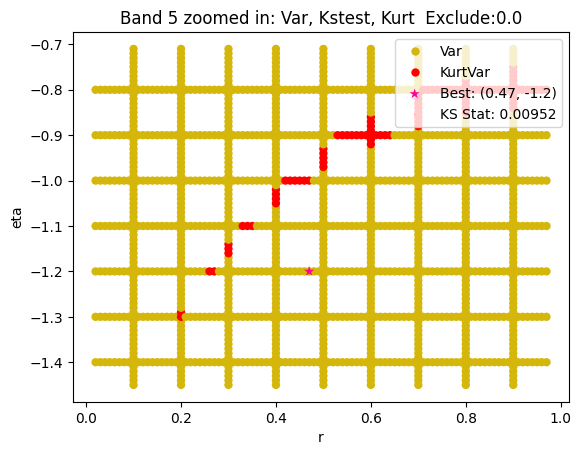

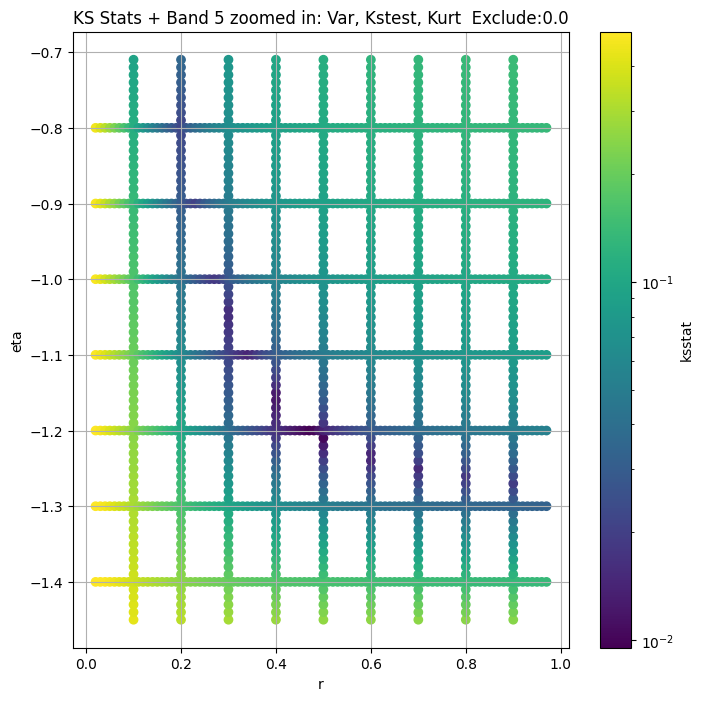

Band 6


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 6, 25.0 + 100 = 125, ksstat: 0.010486118211632922, var: 1.3842755347253943


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 6, 25.0 + 75 = 100, ksstat: 0.010864048574011131, var: 1.407964667416205


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 6, 25.0 + 50 = 75, ksstat: 0.010620544760583939, var: 1.4330363155770618


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 6, 25.0 + 25 = 50, ksstat: 0.011003884465737135, var: 1.4599295172639724


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 6, 25.0 + 0 = 25, ksstat: 0.010730828428692274, var: 1.4890739229110228


  0%|          | 0/1298 [00:00<?, ?it/s]

Finding Minimum after computing 1298 CDFs
band 6, 25.0 + -25 = 0, ksstat: 0.010633979263750246, var: 1.522237153819995
Number of samples: 100000, Without approximation : 548700.0


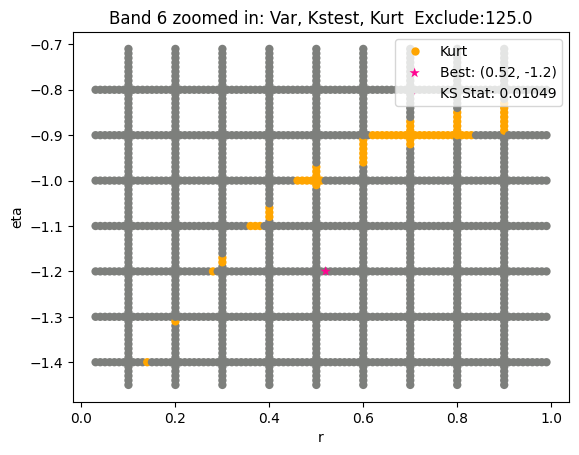

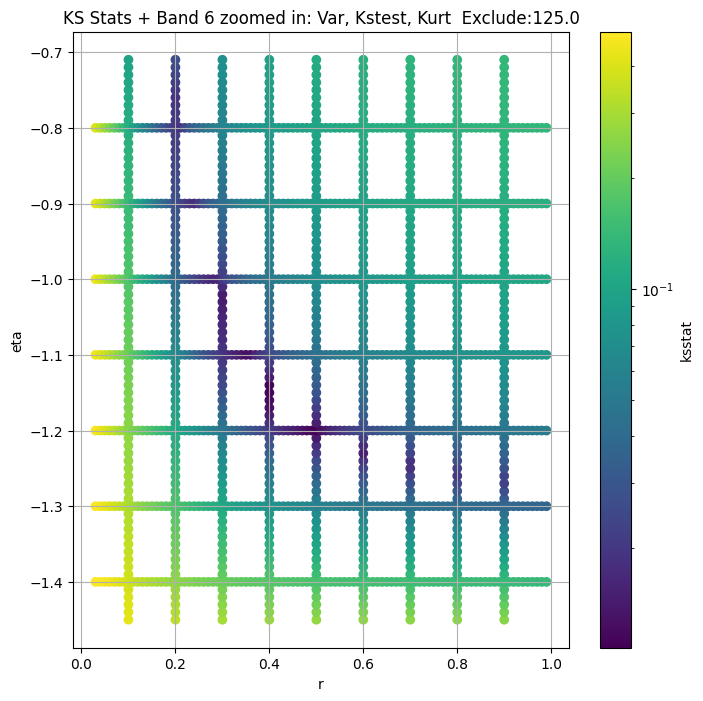

Band 8


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + 100 = 300, ksstat: 0.004805319609669904, var: 0.1247216229650644


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + 75 = 275, ksstat: 0.004353725672769242, var: 0.12733419616128122


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + 50 = 250, ksstat: 0.0042482952207894, var: 0.1301330848287458


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + 25 = 225, ksstat: 0.00443016072373259, var: 0.1331451132262633


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + 0 = 200, ksstat: 0.0040510150866418515, var: 0.13641364493760505


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + -25 = 175, ksstat: 0.0029735363869462517, var: 0.13999250488448003


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + -50 = 150, ksstat: 0.0031855297680622174, var: 0.14393546918703254


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + -75 = 125, ksstat: 0.002647291030624971, var: 0.14834343815402973


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 8, 200.0 + -100 = 100, ksstat: 0.0027218518159779492, var: 0.15336380571680602
Number of samples: 100000, Without approximation : 3556612.0


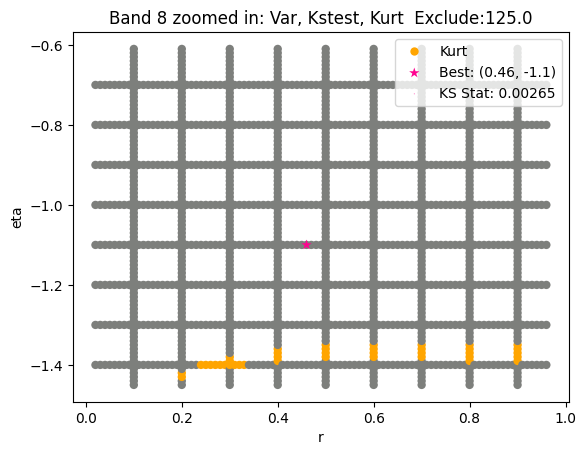

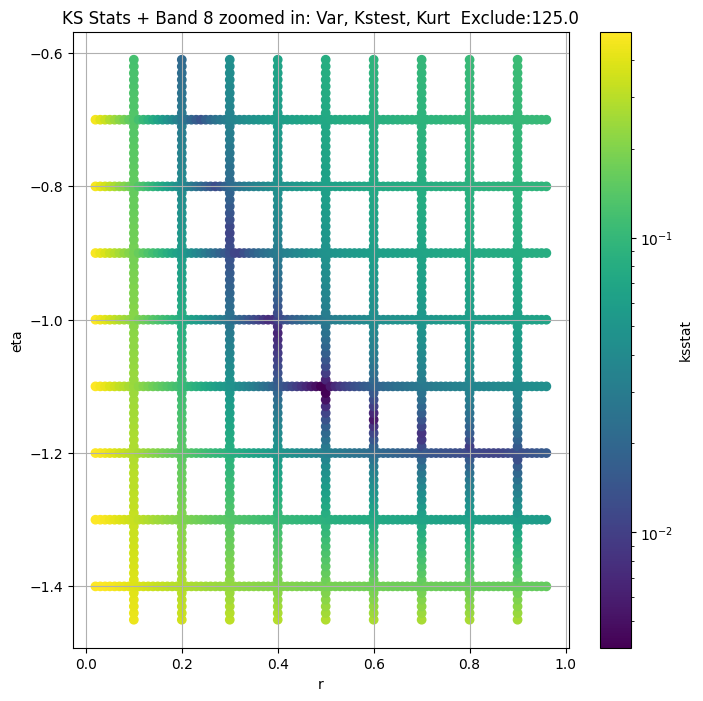

Band 9


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 0.0 + 100 = 100, ksstat: 0.0037661480498509606, var: 0.03953423465510472


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 0.0 + 75 = 75, ksstat: 0.0032580943056755296, var: 0.040524279006687015


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 0.0 + 50 = 50, ksstat: 0.0033513802993446196, var: 0.041707293636536254


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 0.0 + 25 = 25, ksstat: 0.002266826476303982, var: 0.04323545577044636


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 9, 0.0 + 0 = 0, ksstat: 0.0025241327774550015, var: 0.04615971873525968
Number of samples: 100000, Without approximation : 5336598.0


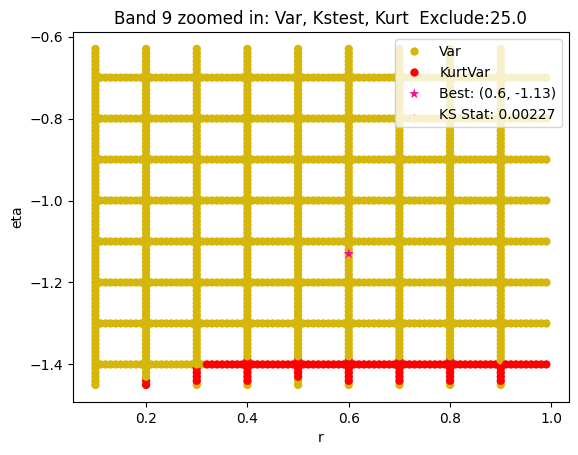

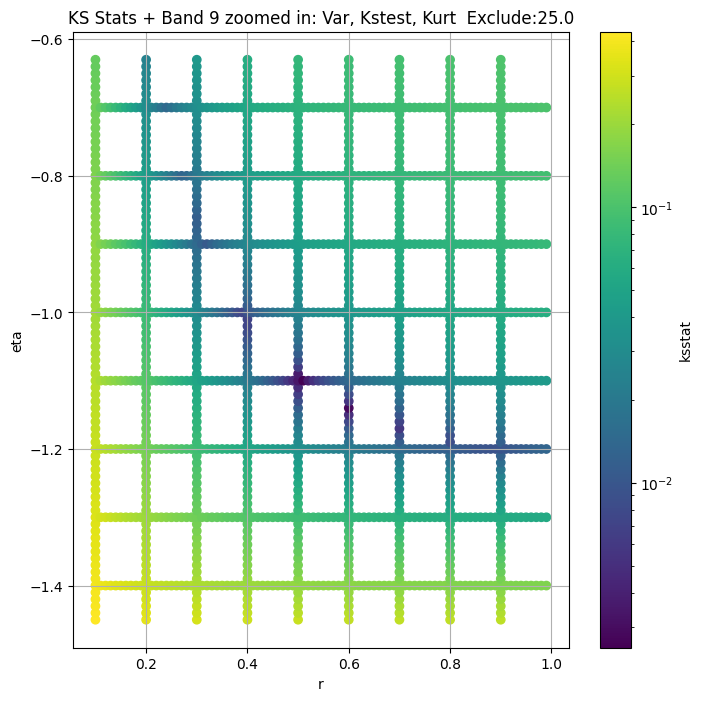

Band 11


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + 100 = 200, ksstat: 0.005247722720556847, var: 0.010556747008030831


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + 75 = 175, ksstat: 0.005665009541717891, var: 0.010938232562909841


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + 50 = 150, ksstat: 0.005969226467852307, var: 0.011359627033061223


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + 25 = 125, ksstat: 0.004796288775117313, var: 0.01183188376645853


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + 0 = 100, ksstat: 0.0052333622701148386, var: 0.012367912152797134


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + -25 = 75, ksstat: 0.0036837686949323656, var: 0.01299040892344953


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + -50 = 50, ksstat: 0.0037440509139350375, var: 0.013737292972254499


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + -75 = 25, ksstat: 0.0034825129491124485, var: 0.014700644779295035


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 11, 100.0 + -100 = 0, ksstat: 0.0032959253354962192, var: 0.01641717683948446
Number of samples: 100000, Without approximation : 6762724.0


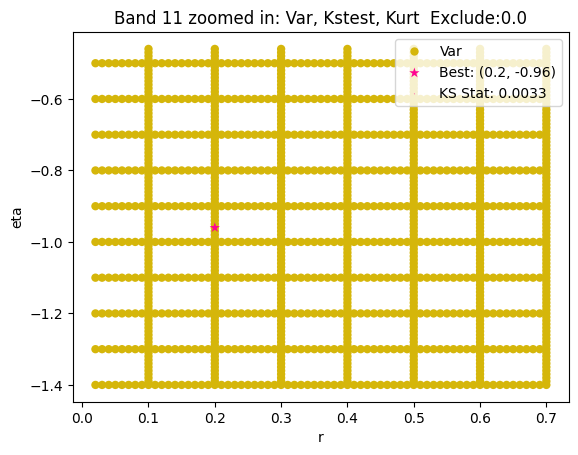

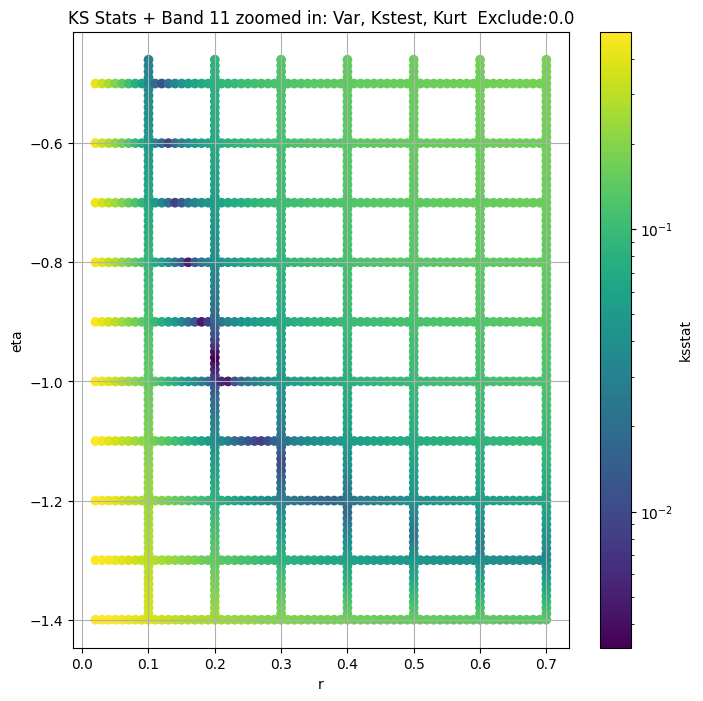

Band 12


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 100 = 125, ksstat: 0.004755635479796053, var: 0.004568004813934022


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 75 = 100, ksstat: 0.004690769966731137, var: 0.004821448749693666


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 50 = 75, ksstat: 0.004982778548438649, var: 0.0051200987709984465


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 25 = 50, ksstat: 0.0032551039885234685, var: 0.005486244537446575


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + 0 = 25, ksstat: 0.0029844308501559835, var: 0.005970641570312991


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 12, 25.0 + -25 = 0, ksstat: 0.0029732752171862664, var: 0.0069256422651946935
Number of samples: 100000, Without approximation : 22271101.0


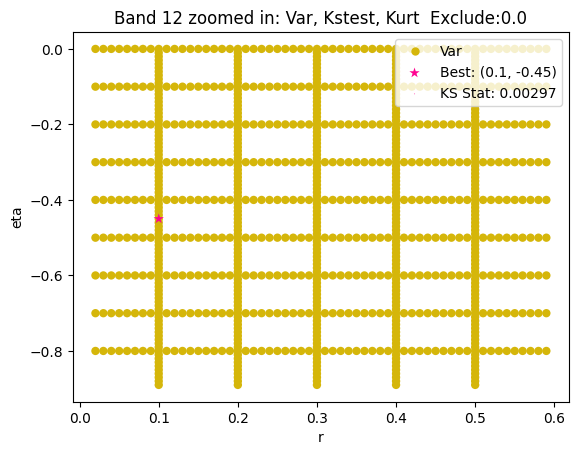

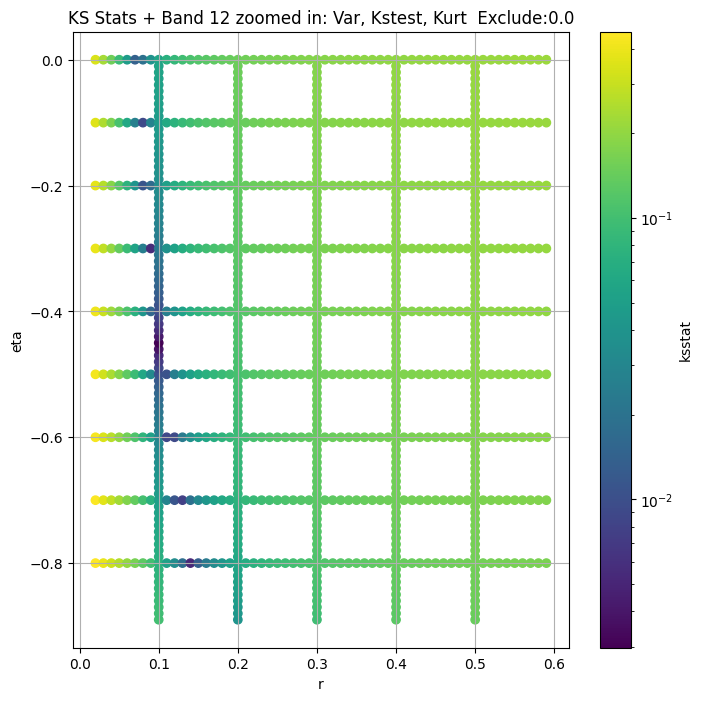

Band 14


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.004702772294398827, var: 0.0002887720859377188


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.0050674124755906436, var: 0.00030416811361891067


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.004435679957711769, var: 0.00032231789109603146


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.00346336336305364, var: 0.00034456335797917065


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.0030425977415355753, var: 0.0003741864145214418


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.0031266956478659402, var: 0.00044216679136780876
Number of samples: 100000, Without approximation : 12539235.0


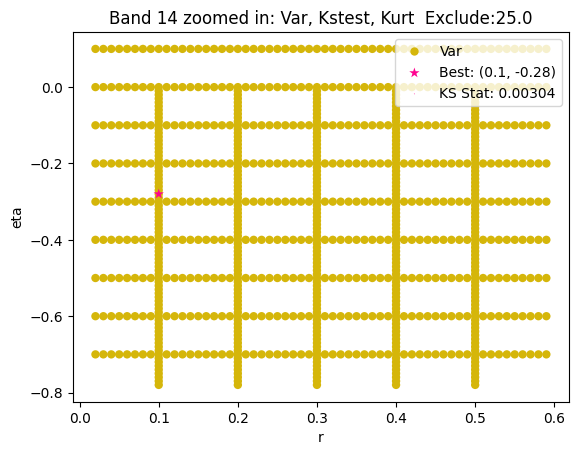

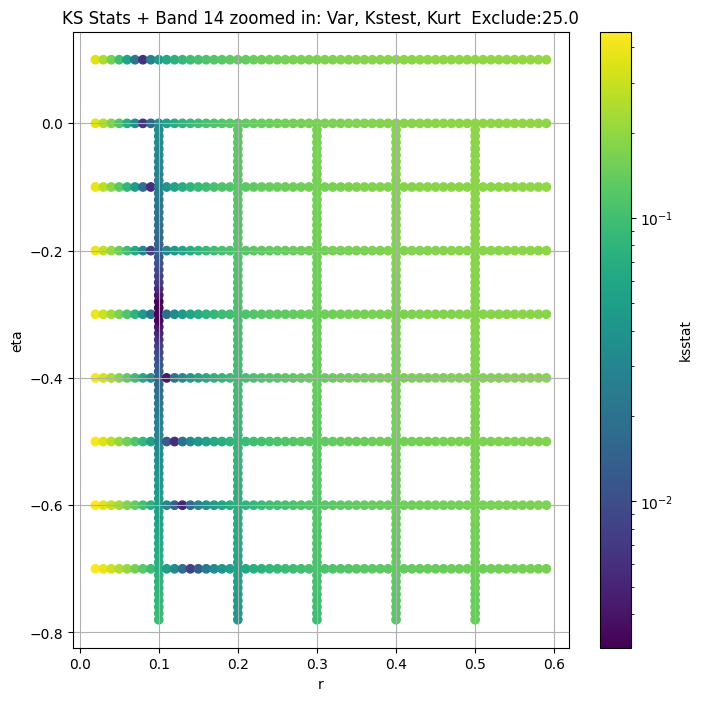

Band 16


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + 100 = 400, ksstat: 0.007500713347086463, var: 1.9577572781257102e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + 75 = 375, ksstat: 0.00807655293612054, var: 2.0514308120216286e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + 50 = 350, ksstat: 0.007466223897909963, var: 2.1549275370429475e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + 25 = 325, ksstat: 0.0067676376013475655, var: 2.2697944685445846e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + 0 = 300, ksstat: 0.006129002935810868, var: 2.3981101422800168e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + -25 = 275, ksstat: 0.006154640772306208, var: 2.5417659040591066e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + -50 = 250, ksstat: 0.006212675180791882, var: 2.704102555659444e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + -75 = 225, ksstat: 0.0061161772001721015, var: 2.8894958165262642e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 300.0 + -100 = 200, ksstat: 0.007859276594669895, var: 3.103563398301663e-05
Number of samples: 100000, Without approximation : 8199664.0


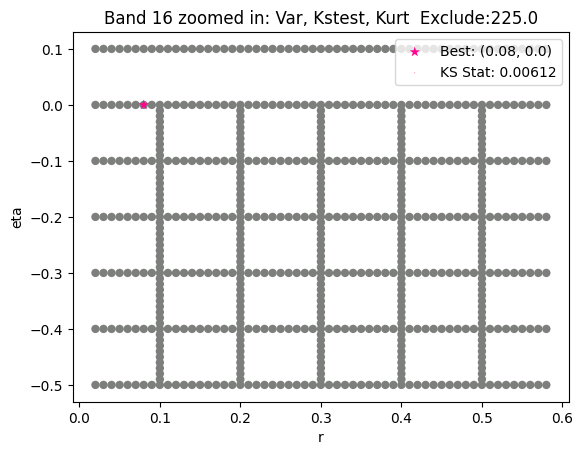

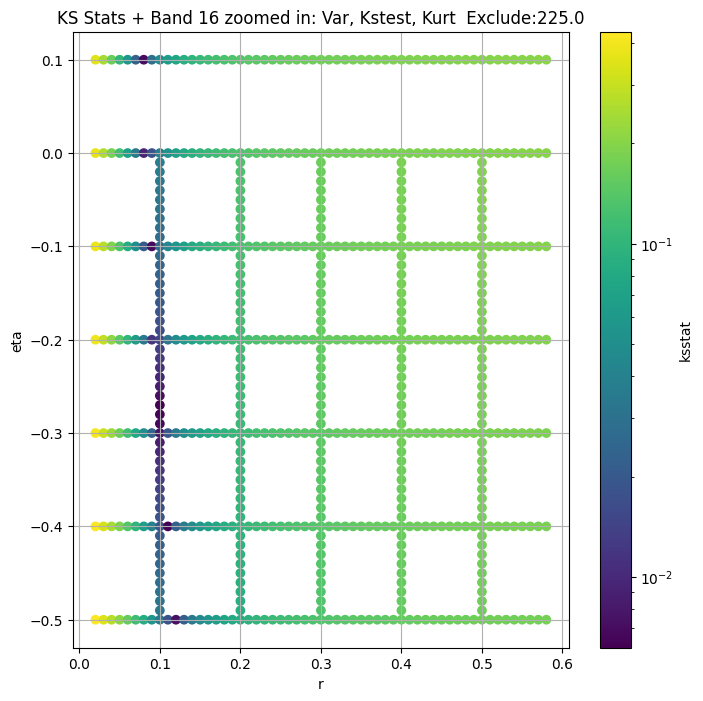

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.016542   0.012634   0.021451  103.542736   54.898436  147.181190   
3     0.167863   0.131724   0.208685   77.699289   61.912070   97.018422   
5     1.805418   1.643466   1.973467   10.639768    9.269359   12.145156   
6     1.522237   1.389193   1.659050    9.897320    8.832308   11.013223   
8     0.189349   0.163776   0.218549   29.697767   20.258654   40.649249   
9     0.046160   0.041017   0.052375   20.315265   11.214986   46.298195   
11    0.016417   0.013539   0.019882   52.739324   32.215677  100.260013   
12    0.006926   0.005489   0.008856   84.103175   44.060635  193.098712   
14    0.000442   0.000345   0.000612  126.152679   41.820439  427.664160   
16    0.000100   0.000063   0.000159  343.486872  118.174578  840.164724   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98473.0             0.004067        0.4         -0.9   
3          109656.0             0.011023        0.1         -0.4   
5         1086255.0             0.010584        0.5         -1.2   
6          548700.0             0.010731        0.5         -1.2   
8         3556612.0             0.004051        0.5         -1.1   
9         5336598.0             0.003448        0.5         -1.1   
11        6762724.0             0.006610        0.2         -0.9   
12       22271101.0             0.004749        0.1         -0.4   
14       12539235.0             0.003155        0.1         -0.3   
16        8199664.0             0.007612        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.362183e-03                   150.0            0.010235   
3      7.439454e-14                   500.0            0.058013   
5      1.755506e+00                    75.0            1.805418   
6      1.551119e+00                    25.0            1.384276   
8      9.473170e-02                   200.0            0.148343   
9      3.205536e-02                     0.0            0.043235   
11     4.907902e-06                   100.0            0.016417   
12     8.905523e-15                    25.0            0.006926   
14     2.923478e-16                    25.0            0.000374   
16     1.873617e-17                   300.0            0.000029   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004326          0.002445    0.38     -0.90   
3                    0.004100          0.009846    0.10     -0.42   
5                    0.001303          0.009523    0.47     -1.20   
6                    0.001833          0.010486    0.52     -1.20   
8                    0.000720          0.002647    0.46     -1.10   
9                    0.000588          0.002267    0.60     -1.13   
11                   0.000522          0.003296    0.20     -0.96   
12                   0.000288          0.002973    0.10     -0.45   
14                   0.000384          0.003043    0.10     -0.28   
16                   0.000474          0.006116    0.08      0.00   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.160013e-03                100.0       315465  
3     9.900541e-14                400.0        19515  
5     1.559341e+00                  0.0        21478  
6     1.608448e+00                125.0        17146  
8     7.795633e-02                125.0       250074  
9     5.435034e-02                 25.0       375228  
11    9.155572e-06                  0.0       178312  
12    1.451781e-14                  0.0       220207  
14    2.581779e-16                 25.0       195925  
16    1.431891e-22                225.

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

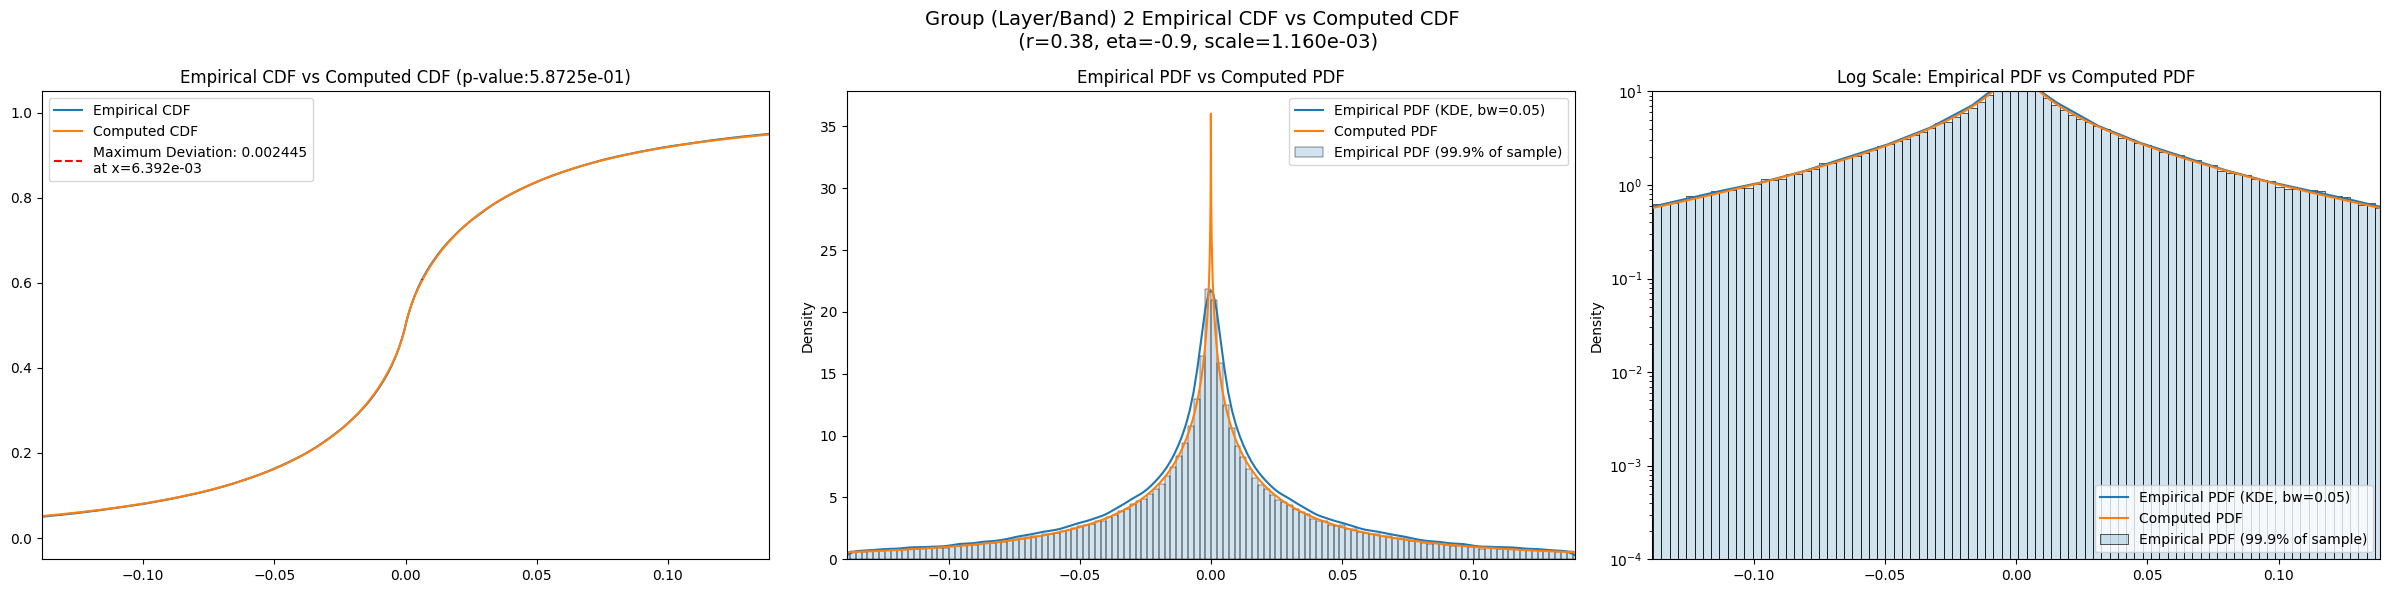

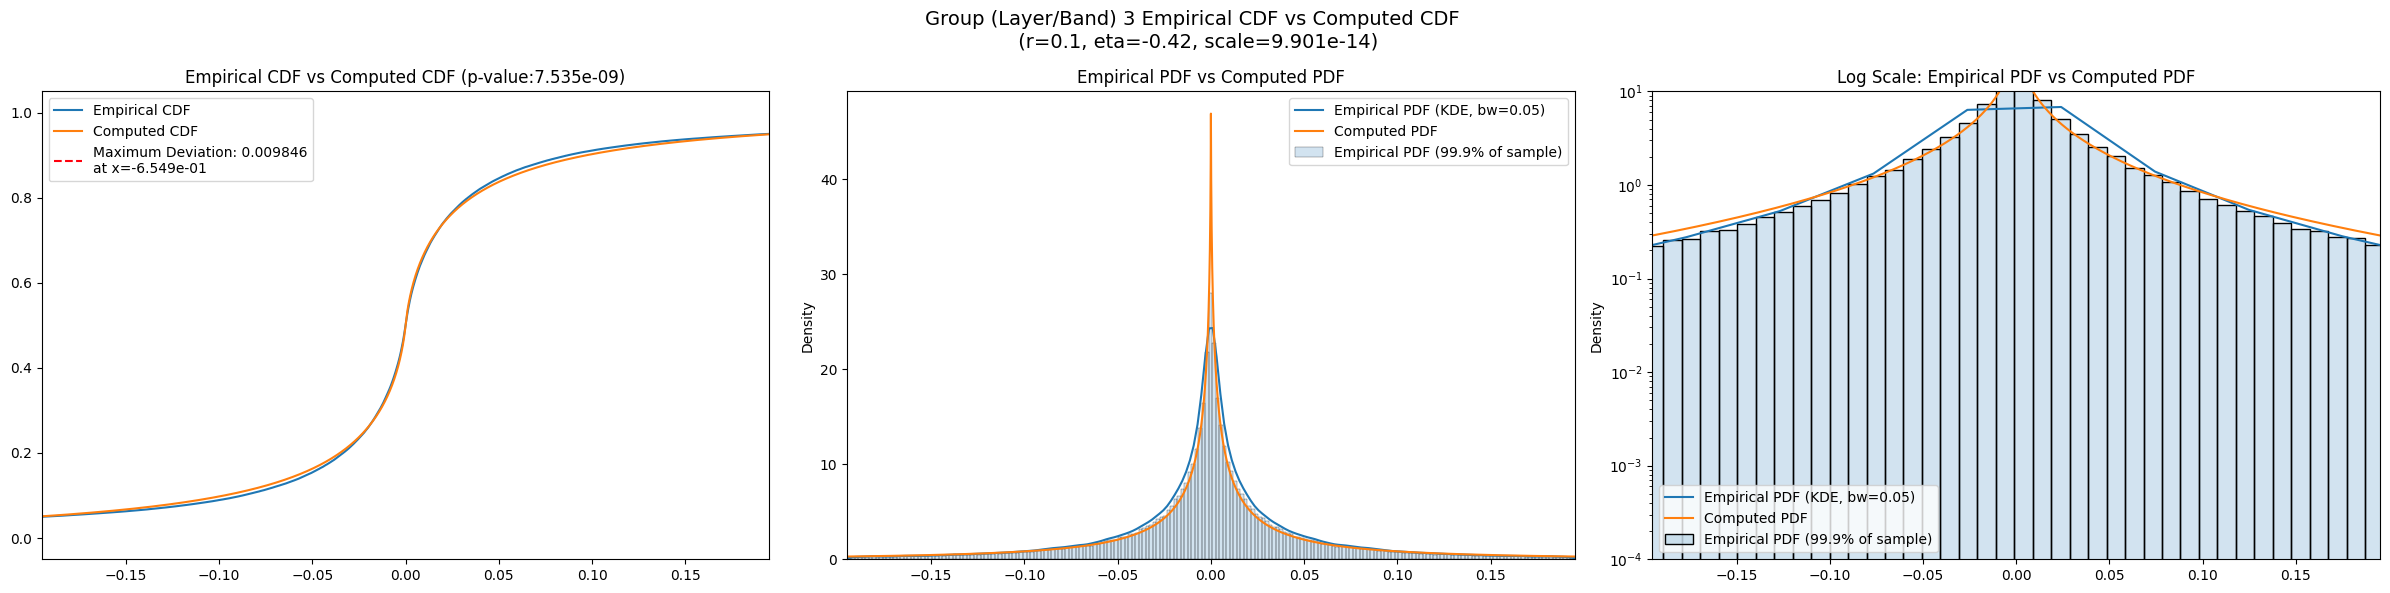

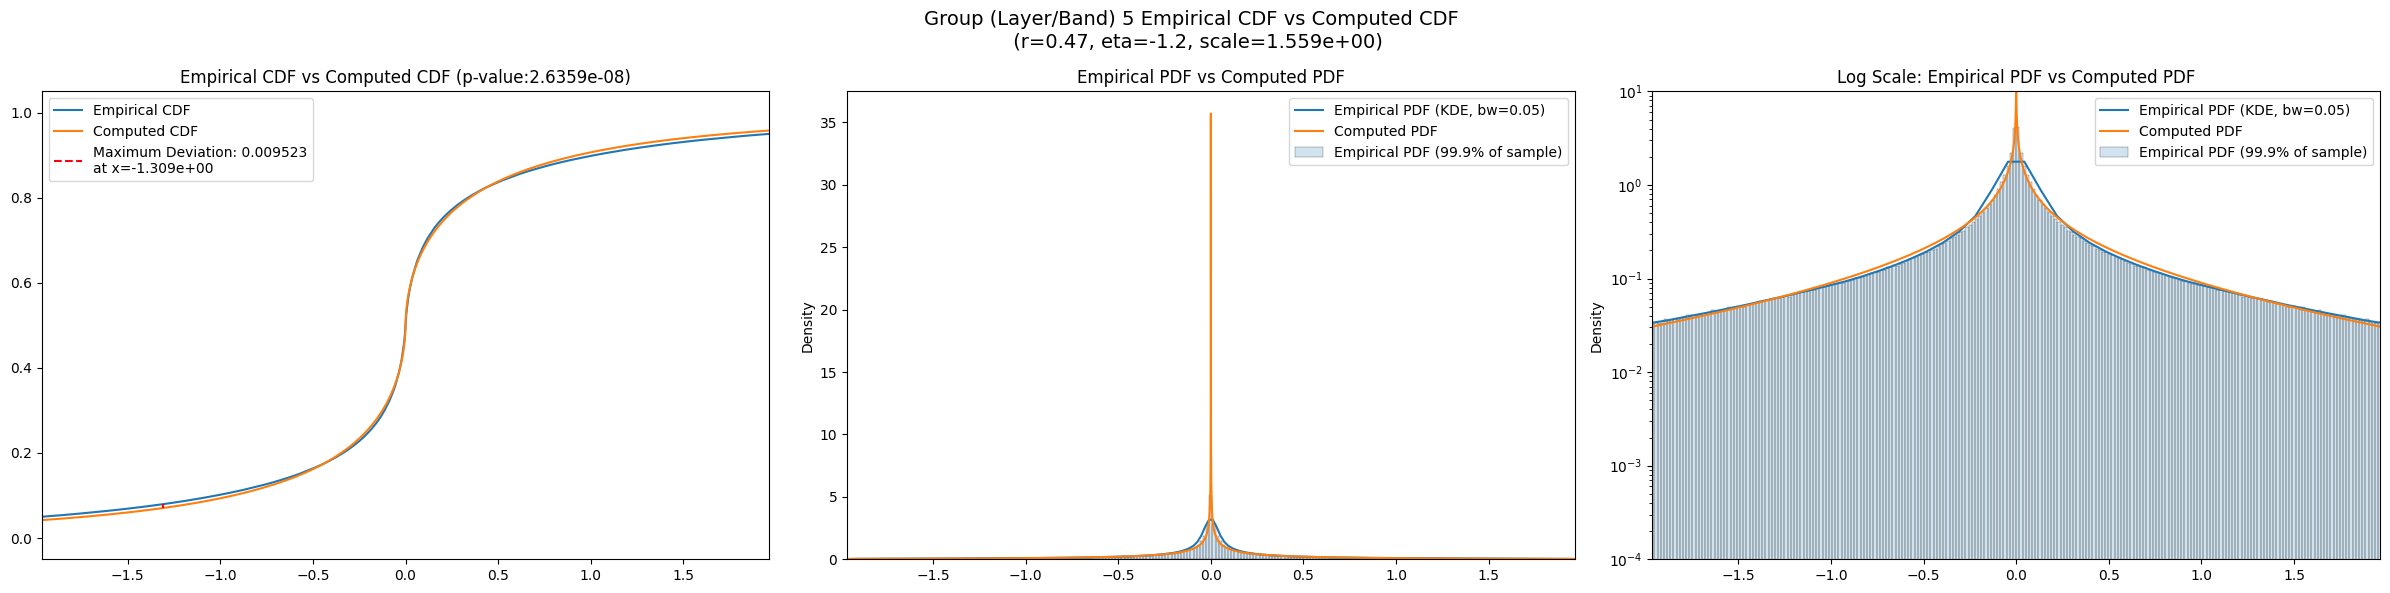

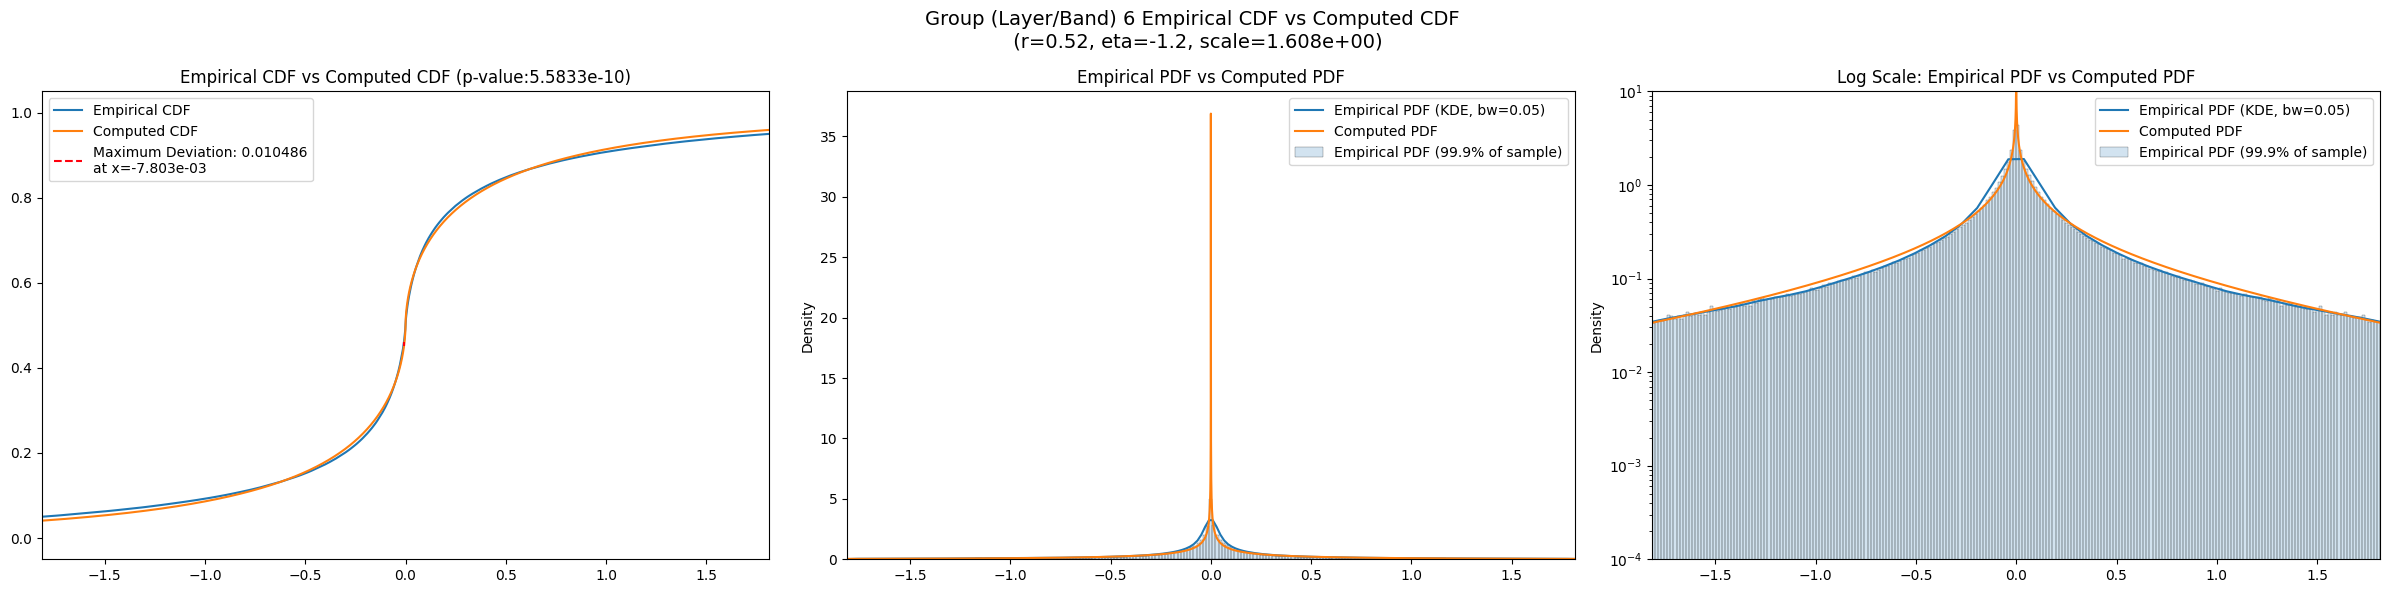

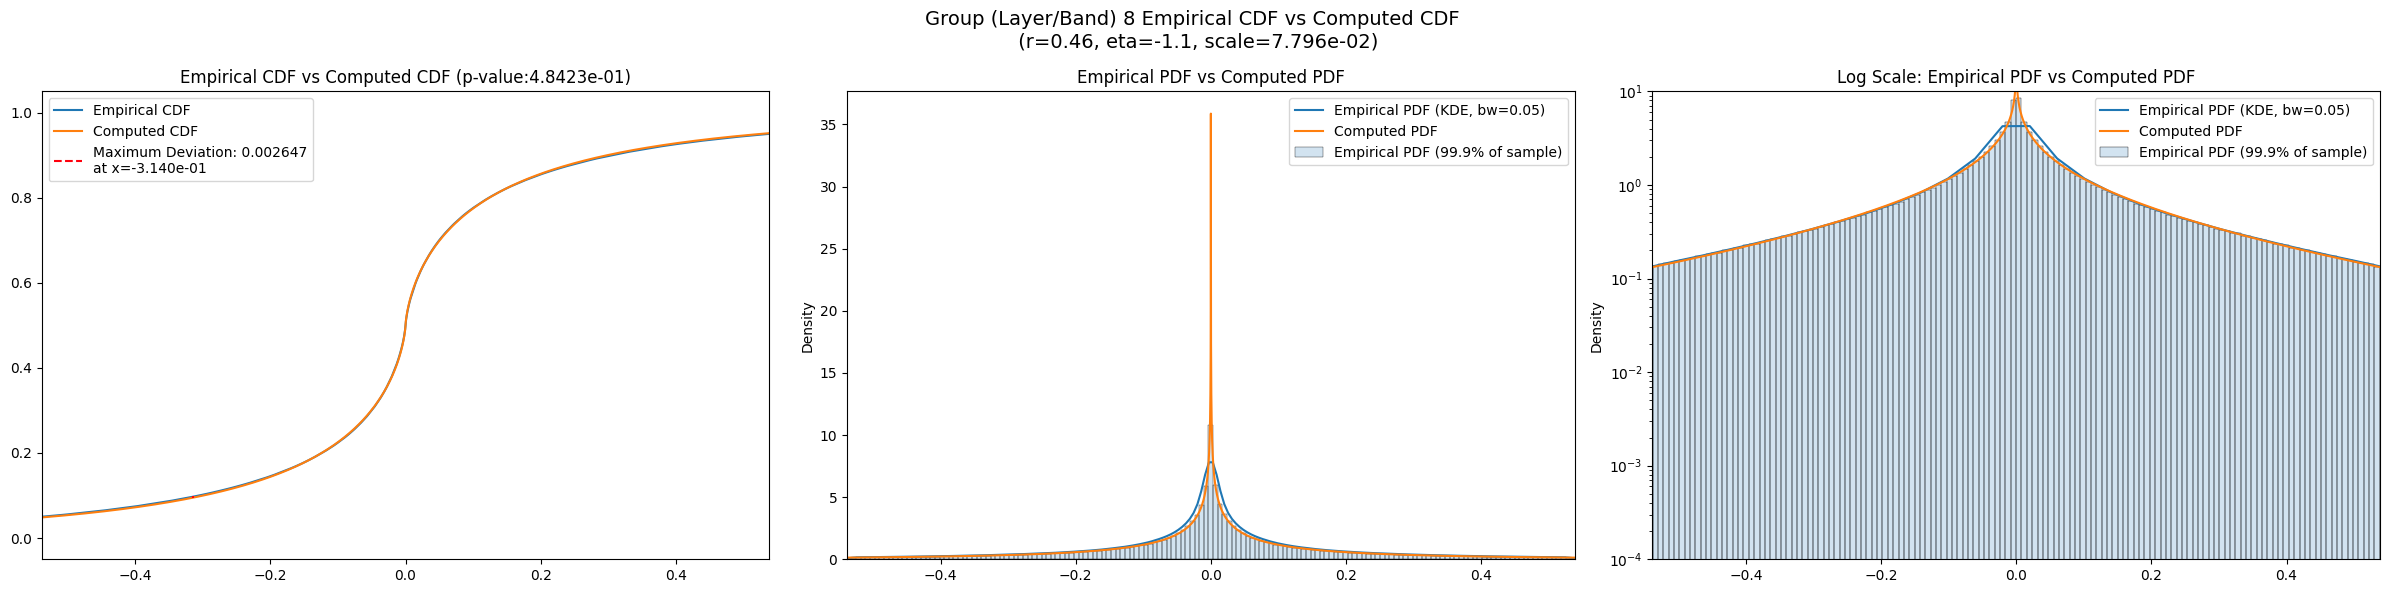

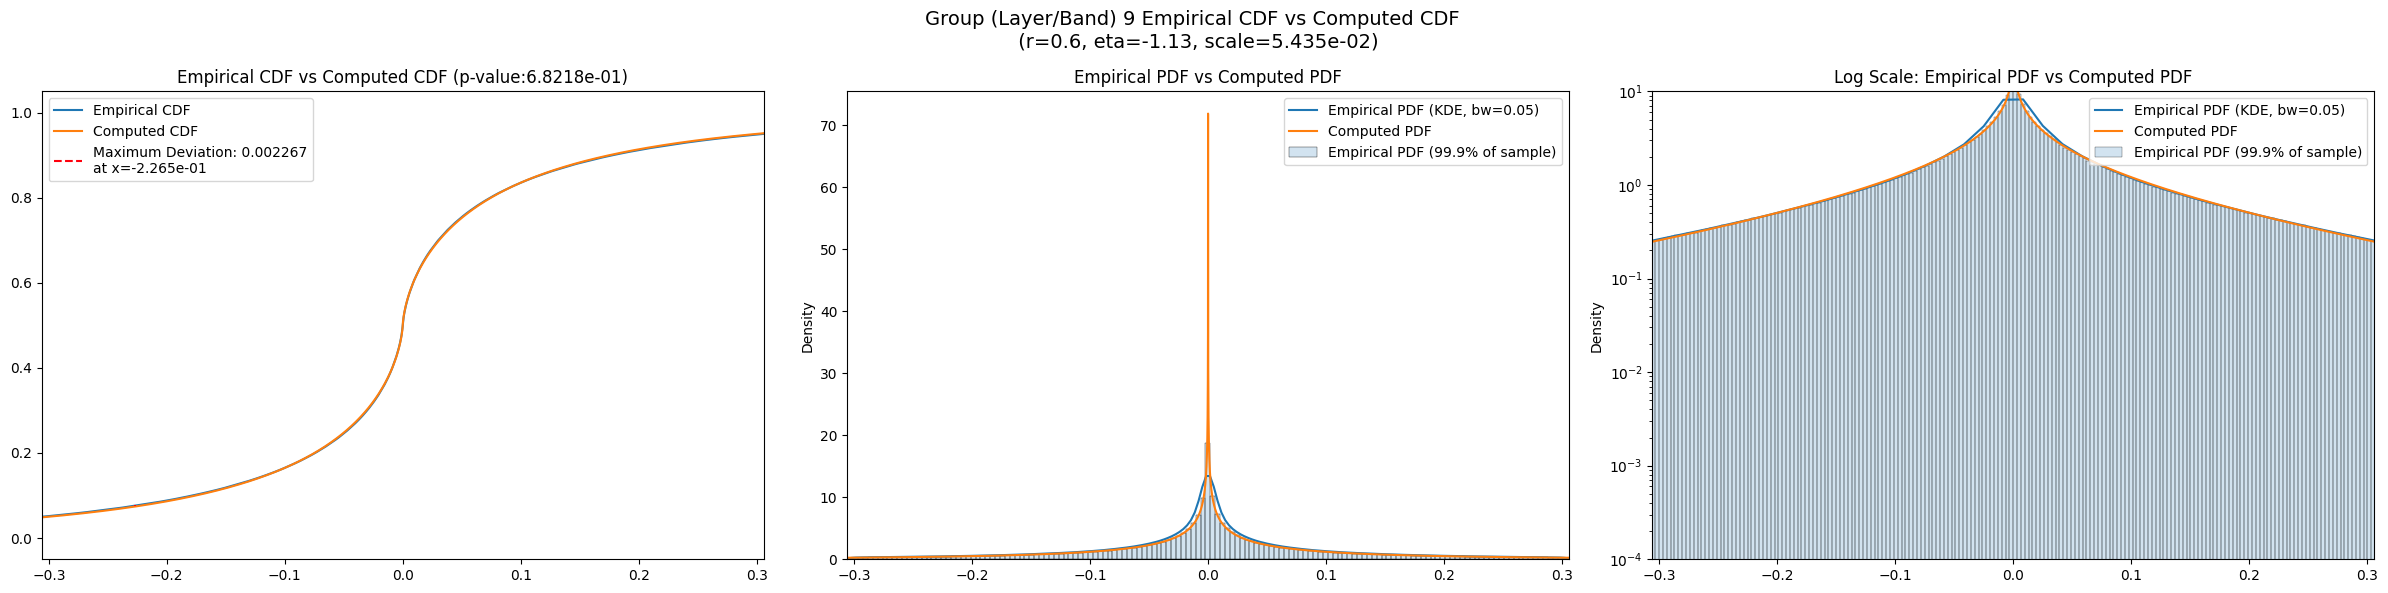

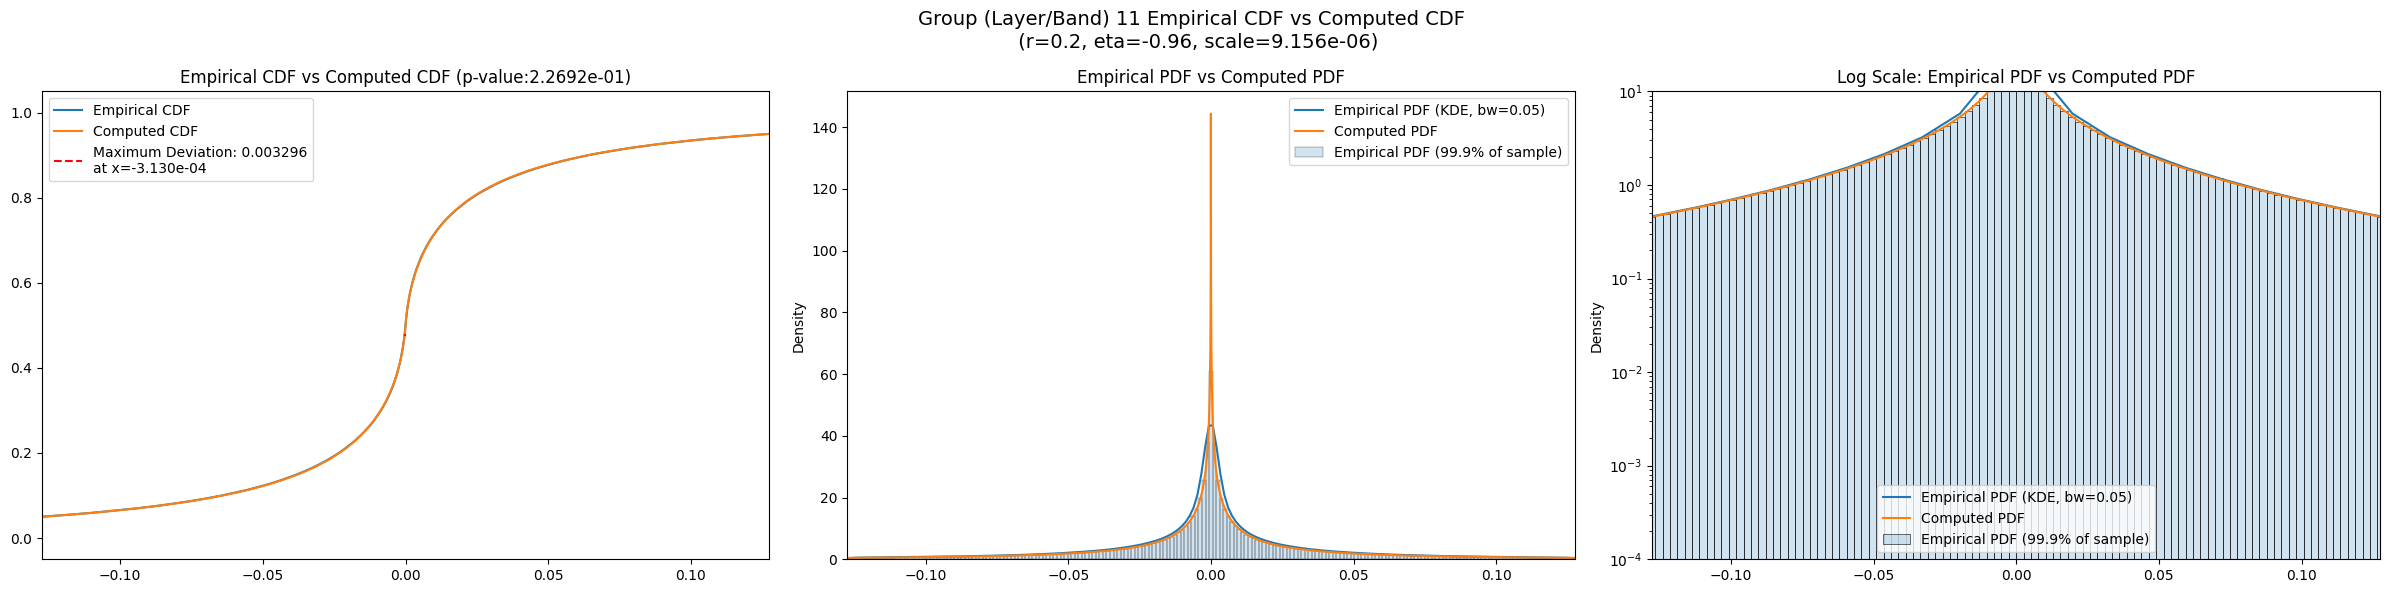

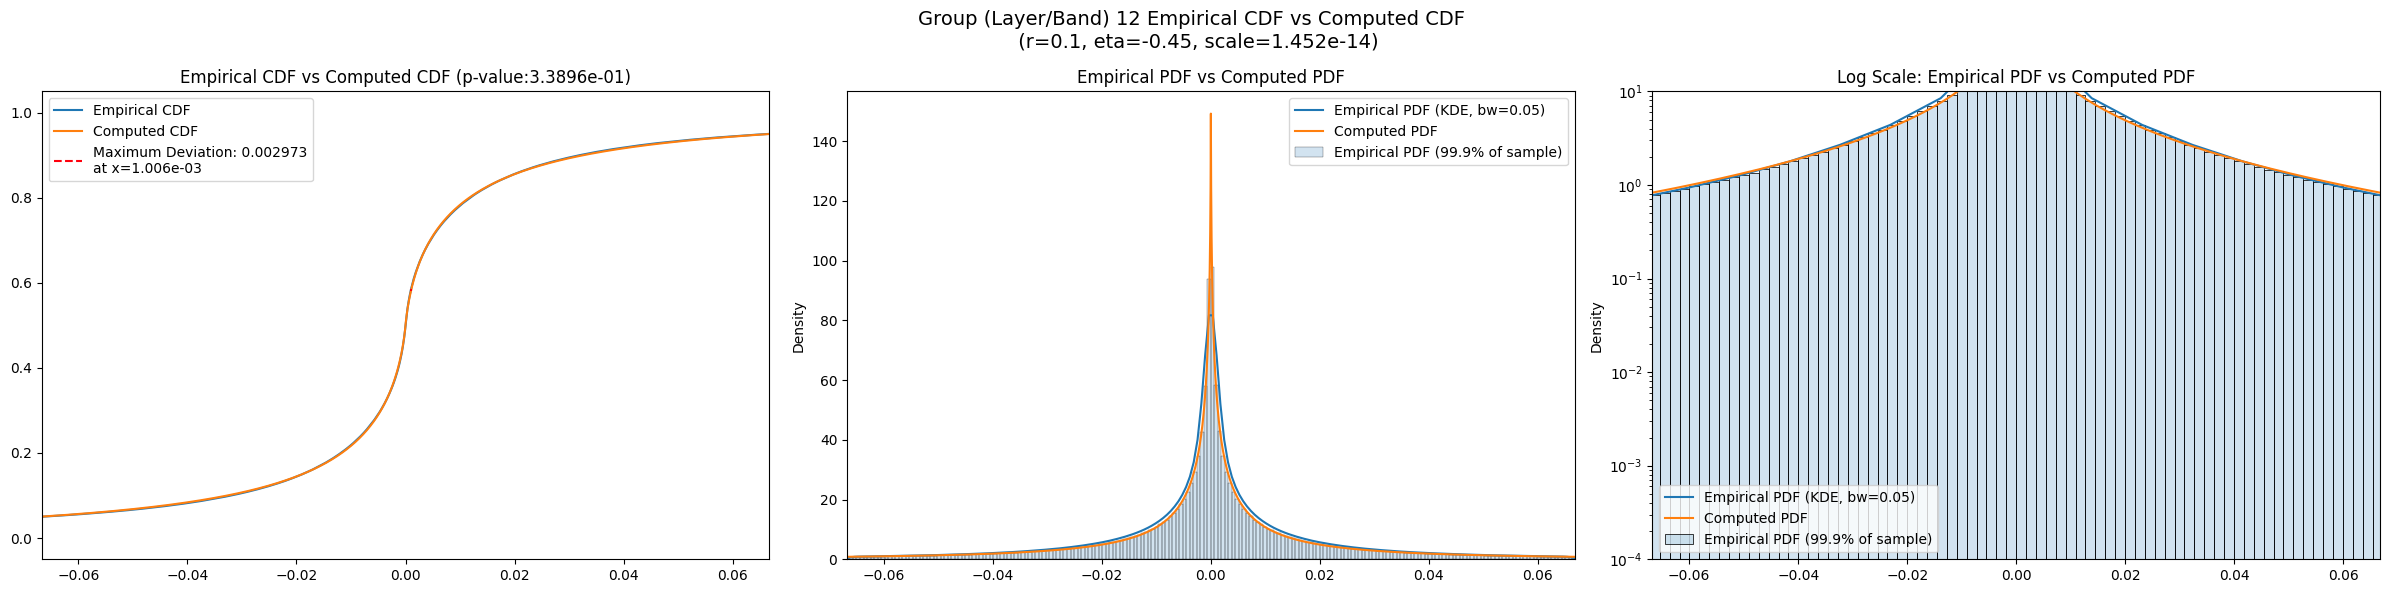

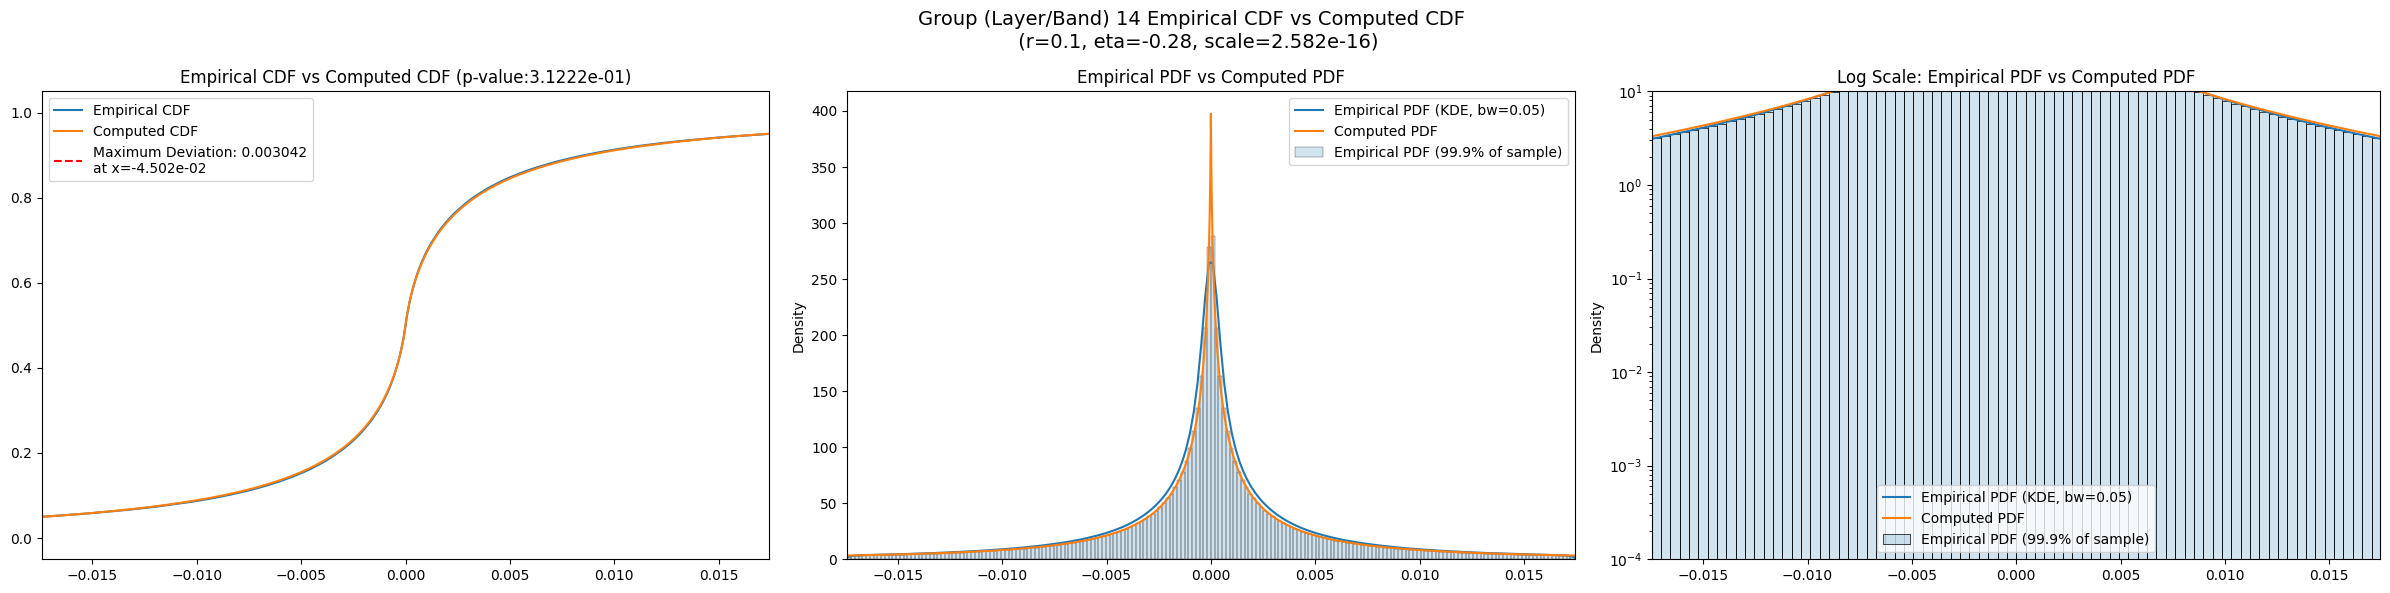

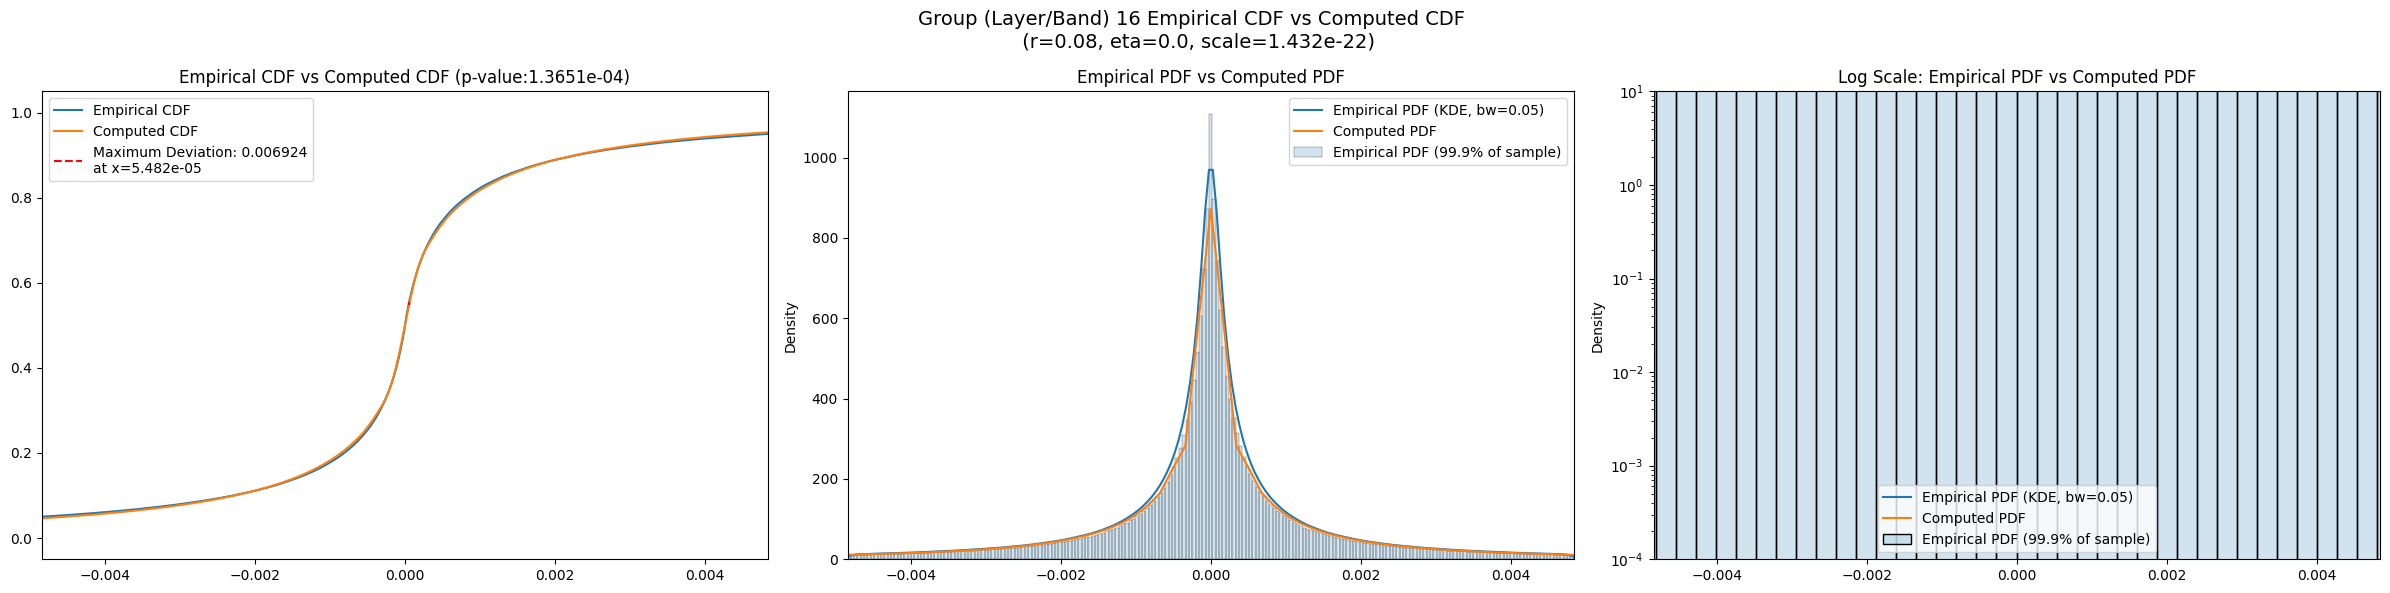

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.016542   0.012634   0.021451  103.542736   54.898436  147.181190   
3     0.167863   0.131724   0.208685   77.699289   61.912070   97.018422   
5     1.805418   1.643466   1.973467   10.639768    9.269359   12.145156   
6     1.522237   1.389193   1.659050    9.897320    8.832308   11.013223   
8     0.189349   0.163776   0.218549   29.697767   20.258654   40.649249   
9     0.046160   0.041017   0.052375   20.315265   11.214986   46.298195   
11    0.016417   0.013539   0.019882   52.739324   32.215677  100.260013   
12    0.006926   0.005489   0.008856   84.103175   44.060635  193.098712   
14    0.000442   0.000345   0.000612  126.152679   41.820439  427.664160   
16    0.000100   0.000063   0.000159  343.486872  118.174578  840.164724   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           98473.0             0.004067        0.4         -0.9  ...   
3          109656.0             0.011023        0.1         -0.4  ...   
5         1086255.0             0.010584        0.5         -1.2  ...   
6          548700.0             0.010731        0.5         -1.2  ...   
8         3556612.0             0.004051        0.5         -1.1  ...   
9         5336598.0             0.003448        0.5         -1.1  ...   
11        6762724.0             0.006610        0.2         -0.9  ...   
12       22271101.0             0.004749        0.1         -0.4  ...   
14       12539235.0             0.003155        0.1         -0.3  ...   
16        8199664.0             0.007612        0.1         -0.3  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           0.047316              0.063739                   0.0   
3           0.044791              0.076882                   0.0   
5           0.419858              0.095175                   0.0   
6           0.391777              0.090943                   0.0   
8           0.155156              0.076181                   0.0   
9           0.091618              0.074753                   0.0   
11          0.029211              0.086629                   0.0   
12          0.015101              0.083372                   0.0   
14          0.004242              0.079348                   0.0   
16          0.001105              0.081868                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          0.040906             0.037689        5.723400e-122  0.032189   
3          0.039774             0.052646        1.385390e-264  0.029987   
5          0.360389             0.071085         0.000000e+00  0.274830   
6          0.340126             0.066463         0.000000e+00  0.258948   
8          0.133218             0.050866         0.000000e+00  0.103893   
9          0.078167             0.049826         0.000000e+00  0.061207   
11         0.025110             0.062384         0.000000e+00  0.019220   
12         0.013048             0.059253         0.000000e+00  0.009935   
14         0.003713             0.054378         0.000000e+00  0.002840   
16         0.000976             0.056918         0.000000e+00  0.000747   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.039772  8.881970e-136          5.971272e-01  
3          0.050319  9.749950e-242          1.158497e-09  
5          0.071166   0.000000e+00          5.392020e-86  
6          0.065678   0.000000e+00          7.780465e-53  
8          0.052400   0.000000e+00          4.471460e-22  
9          0.051986   0.000000e+00          3.032648e-24  
11         0.062582   0.000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.004067                 0.004326          0.002445   
3                0.011023                 0.004100          0.009846   
5                0.010584                 0.001303          0.009523   
6                0.010731                 0.001833          0.010486   
8                0.004051                 0.000720          0.002647   
9                0.003448                 0.000588          0.002267   
11               0.006610                 0.000522          0.003296   
12               0.004749                 0.000288          0.002973   
14               0.003155                 0.000384          0.003043   
16               0.007612                 0.000474          0.006116   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.063739             0.037689       0.039772  
3                 0.076882             0.052646       0.050319  
5                 0.095175             0.071085       0.071166  
6                 0.090943             0.066463       0.065678  
8                 0.076181             0.050866       0.052400  
9                 0.074753             0.049826       0.051986  
11                0.086629             0.062384       0.062582  
12                0.083372             0.059253       0.059019  
14                0.079348             0.054378       0.053393  
16                0.081868             0.056918       0.054482

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               0.010235          0.002445    0.38     -0.90  1.160013e-03   
3               0.058013          0.009846    0.10     -0.42  9.900541e-14   
5               1.805418          0.009523    0.47     -1.20  1.559341e+00   
6               1.384276          0.010486    0.52     -1.20  1.608448e+00   
8               0.148343          0.002647    0.46     -1.10  7.795633e-02   
9               0.043235          0.002267    0.60     -1.13  5.435034e-02   
11              0.016417          0.003296    0.20     -0.96  9.155572e-06   
12              0.006926          0.002973    0.10     -0.45  1.451781e-14   
14              0.000374          0.003043    0.10     -0.28  2.581779e-16   
16              0.000029          0.006116    0.08      0.00  1.431891e-22   

      best_exclude_cutoff  
band                       
2                   100.0  
3                   400.0  
5                     0.0  
6                   125.0  
8                   125.0  
9                    25.0  
11                    0.0  
12                    0.0  
14                   25.0  
16                  225.0